# Search for new physics - find the Z' particle
In this exciting project, we are going to create a binary classifier that distinguishes between the Standard Model (SM) physics processes and a specific extension of the SM, which introduces a novel particle known as Z', also known as Z Prime Boson. Additionally, we will try to perform mass estimation of the Z' particle . We will be using simulated Monte Carlo (MC) data. This project aims to harness the power of Machine Learning and Deep Learning to advance the exploration of new physics. The success of this endeavor has the potential to offer physicists valuable tools for enhancing our comprehension of the universe, potentially shedding light on unresolved phenomena, such as the enigmatic existence of dark matter, which currently challenges the predictions of the Standard Model.

In part 1/3, we train a binary classifier - random forest model.
In part 2/3, we train a Neural Network model.
In part 3/3, we use our best model to identify, then try to calculate mass of the Z' particle

### Import libraries

In [51]:
# Import necessary libraries
import pandas as pd
import numpy as np
import h5py
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import joblib
import time

#### Configurations

In [3]:
# Set a fixed seed for reproducibility -> This assures consistent results on the training data
fixed_seed = 42
np.random.seed(fixed_seed)

### Specify path to the dataset and list the background/signal files

In [4]:
# Specify the correct path to your file on Kaggle
path = '/kaggle/input/zparticlesearch/mc_110901.ZPrime500/'

# Specify which file you want to work with here
file_name = '/mc_105986.ZZ.hdf5'

# Open the file as readonly'
f_data = h5py.File(path + file_name, 'r')

# List all groups
data = pd.DataFrame(f_data['mini'][:])

### List background and signal files
The Monte Carlo simulated datasets are available at Cern opendata (CMS Open Data). See the dataset details for more info.
Each dataset has a description of what the datasets simulates. This way we could easily distict between background and signal files, where signal files are the simulated data that may prove the presense of the hypothetical Z' particle.

In [5]:
# List of background files
background_files = [
    'mc_105986.ZZ.hdf5',
    'mc_105987.WZ.hdf5',
    'mc_110090.stop_tchan_top.hdf5',
    'mc_110091.stop_tchan_antitop.hdf5',
    'mc_110119.stop_schan.hdf5',
    'mc_110140.stop_wtchan.hdf5',
    'mc_117049.ttbar_had.hdf5',
    'mc_117050.ttbar_lep.hdf5',
    'mc_147770.Zee.hdf5',
    'mc_147771.Zmumu.hdf5',
    'mc_147772.Ztautau.hdf5',
    'mc_167740.WenuWithB.hdf5',
    'mc_167743.WmunuWithB.hdf5',
    'mc_167746.WtaunuWithB.hdf5',
    'mc_173041.DYeeM08to15.hdf5',
    'mc_173042.DYeeM15to40.hdf5',
    'mc_173043.DYmumuM08to15.hdf5',
    'mc_173044.DYmumuM15to40.hdf5',
    'mc_173045.DYtautauM08to15.hdf5',
    'mc_173046.DYtautauM15to40.hdf5'
]


# List of signal files
signal_files = [
    'mc_110901.ZPrime500.hdf5',
    'mc_110902.ZPrime750.hdf5',
    'mc_110903.ZPrime1000.hdf5',
    'mc_110905.ZPrime1500.hdf5',
    'mc_110906.ZPrime1750.hdf5',
    'mc_110907.ZPrime2000.hdf5',
    'mc_110909.ZPrime2500.hdf5'
]

### Inspect the Dataset

In [6]:
# Print the first few rows of the DataFrame
pd.set_option('display.max_columns', None) # Set the option to display all columns
data.head()

,alljet_n,channelNumber,eventNumber,jet_1_E,jet_1_MV1,jet_1_SV0,jet_1_eta,jet_1_jvf,jet_1_m,jet_1_phi,jet_1_pt,jet_1_trueflav,jet_1_truthMatched,jet_2_E,jet_2_MV1,jet_2_SV0,jet_2_eta,jet_2_jvf,jet_2_m,jet_2_phi,jet_2_pt,jet_2_trueflav,jet_2_truthMatched,jet_3_E,jet_3_MV1,jet_3_SV0,jet_3_eta,jet_3_jvf,jet_3_m,jet_3_phi,jet_3_pt,jet_3_trueflav,jet_3_truthMatched,jet_4_E,jet_4_MV1,jet_4_SV0,jet_4_eta,jet_4_jvf,jet_4_m,jet_4_phi,jet_4_pt,jet_4_trueflav,jet_4_truthMatched,jet_5_E,jet_5_MV1,jet_5_SV0,jet_5_eta,jet_5_jvf,jet_5_m,jet_5_phi,jet_5_pt,jet_5_trueflav,jet_5_truthMatched,jet_6_E,jet_6_MV1,jet_6_SV0,jet_6_eta,jet_6_jvf,jet_6_m,jet_6_phi,jet_6_pt,jet_6_trueflav,jet_6_truthMatched,jet_7_E,jet_7_MV1,jet_7_SV0,jet_7_eta,jet_7_jvf,jet_7_m,jet_7_phi,jet_7_pt,jet_7_trueflav,jet_7_truthMatched,jet_8_E,jet_8_MV1,jet_8_SV0,jet_8_eta,jet_8_jvf,jet_8_m,jet_8_phi,jet_8_pt,jet_8_trueflav,jet_8_truthMatched,jet_9_E,jet_9_MV1,jet_9_SV0,jet_9_eta,jet_9_jvf,jet_9_m,jet_9_phi,jet_9_pt,jet_9_trueflav,jet_9_truthMatched,jet_n,lep_1_E,lep_1_charge,lep_1_eta,lep_1_etcone20,lep_1_flag,lep_1_phi,lep_1_pt,lep_1_ptcone30,lep_1_trackd0pvunbiased,lep_1_tracksigd0pvunbiased,lep_1_type,lep_1_z0,lep_2_E,lep_2_charge,lep_2_eta,lep_2_etcone20,lep_2_flag,lep_2_phi,lep_2_pt,lep_2_ptcone30,lep_2_trackd0pvunbiased,lep_2_tracksigd0pvunbiased,lep_2_type,lep_2_z0,lep_3_E,lep_3_charge,lep_3_eta,lep_3_etcone20,lep_3_flag,lep_3_phi,lep_3_pt,lep_3_ptcone30,lep_3_trackd0pvunbiased,lep_3_tracksigd0pvunbiased,lep_3_type,lep_3_z0,lep_4_E,lep_4_charge,lep_4_eta,lep_4_etcone20,lep_4_flag,lep_4_phi,lep_4_pt,lep_4_ptcone30,lep_4_trackd0pvunbiased,lep_4_tracksigd0pvunbiased,lep_4_type,lep_4_z0,lep_5_E,lep_5_charge,lep_5_eta,lep_5_etcone20,lep_5_flag,lep_5_phi,lep_5_pt,lep_5_ptcone30,lep_5_trackd0pvunbiased,lep_5_tracksigd0pvunbiased,lep_5_type,lep_5_z0,lep_n,lep_trigMatched,mcWeight,met_et,met_phi,pvxp_n,runNumber,scaleFactor_BTAG,scaleFactor_ELE,scaleFactor_JVFSF,scaleFactor_MUON,scaleFactor_PILEUP,scaleFactor_TRIGGER,scaleFactor_ZVERTEX,vxp_z
0,0,105986,25001,54897.203125,0.059601,0.000000,0.143288,0.882837,6843.874023,-0.298063,53914.511719,0,1,87731.015625,0.116885,0.0,-1.108722,0.511836,5493.526855,0.059560,52111.167969,0,1,65074.261719,0.058257,0.0,-0.791613,0.858343,6688.428223,-0.328393,48667.664062,0,1,40973.019531,0.058846,0.0,0.002223,0.862189,6724.734375,2.909748,40417.300781,0,1,135741.25,0.059625,0.0,-2.223047,0.736373,4504.304199,2.825874,29039.128906,0,1,37984.300781,0.052396,0.0,-0.806043,0.0,7321.072266,-0.962507,27756.451172,0,0,41844.773438,0.052396,0.0,0.896861,0.0,3981.717529,1.347423,29131.917969,0,0,77520.414062,0.308235,0.0,1.645905,0.30565,6695.60498,-2.637031,28718.089844,0,1,108869.257812,0.059399,0.0,-2.052256,0.408364,5281.11084,1.49879,27481.082031,0,1,0,35308.468750,-1.0,-0.261758,54.295437,1309114624,0.659947,34132.289062,0.000000,0.006909,0.017931,1095761920,-0.093284,30114.939453,1.0,-0.697808,616.163330,1269833728,-0.485311,24024.353516,0.0,0.011484,0.015375,1095761920,0.014866,16151.847656,1.0,1.773693,2708.451172,1300923136,0.961914,5328.63916,0.0,-0.039421,0.057254,1093664768,-0.045924,9379.862305,1.0,0.904248,6796.676758,1233185784,1.351579,6525.303711,7273.309082,0.068563,0.030913,1093664768,0.123387,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,1,1,1.0,13005.886719,2.876399,6,195847,1.000000,1.000000,1.0,1.001046,2.186532,0.958796,0.095748,-166.555191
1,1,105986,25003,171373.312500,0.056311,0.000000,-2.006945,0.582158,8385.192383,0.490301,45193.195312,0,1,87731.015625,0.116885,0.0,-1.108722,0.511836,5493.526855,0.059560,52111.167969,0,1,65074.261719,0.058257,0.0,-0.791613,0.858343,6688.428223,-0.328393,48667.664062,0,1,40973.019531,0.058846,0.0,0.002223,0.862189,6724.734375,2.909748,40417.300781,0,1,135741.25,0.059625,0.0,-2.223047,0.736373,4504.304199,2.825874,29039.128906,0,1,37984.300781,0.052396,0.0,-0.806043,0.0,7321.072266,-0.962507,27756.451172,0,0,41844.773438,0.052396,0.0,0.896861,0.0,3981.717529,1.347423,29131.917969,0,0,77520.4

In [7]:
# Check the DataFrame's structure (size, column data types and memory usage)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Columns: 169 entries, alljet_n to vxp_z
dtypes: float32(133), int32(36)
memory usage: 80.6 MB


In [8]:
# Check for missing values
pd.set_option('display.max_rows', None) # Print all rows
data.isnull().sum()

alljet_n                      0
channelNumber                 0
eventNumber                   0
jet_1_E                       0
jet_1_MV1                     0
jet_1_SV0                     0
jet_1_eta                     0
jet_1_jvf                     0
jet_1_m                       0
jet_1_phi                     0
jet_1_pt                      0
jet_1_trueflav                0
jet_1_truthMatched            0
jet_2_E                       0
jet_2_MV1                     0
jet_2_SV0                     0
jet_2_eta                     0
jet_2_jvf                     0
jet_2_m                       0
jet_2_phi                     0
jet_2_pt                      0
jet_2_trueflav                0
jet_2_truthMatched            0
jet_3_E                       0
jet_3_MV1                     0
jet_3_SV0                     0
jet_3_eta                     0
jet_3_jvf                     0
jet_3_m                       0
jet_3_phi                     0
jet_3_pt                      0
jet_3_tr

### Plot All the Features

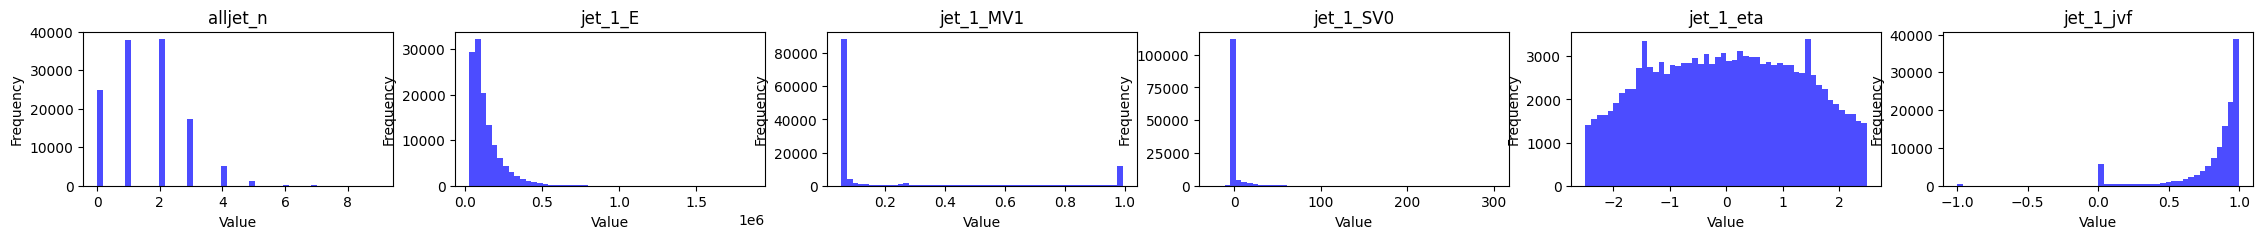

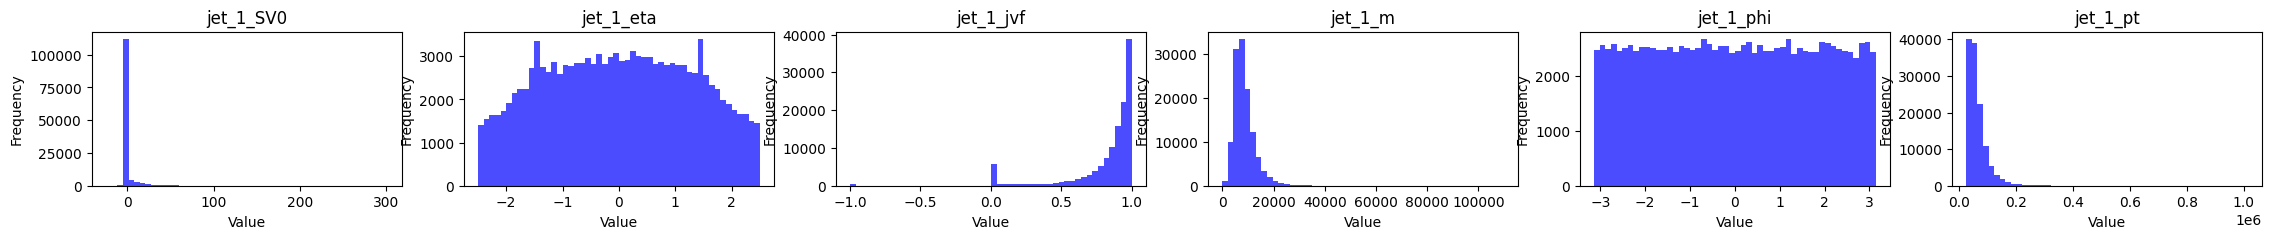

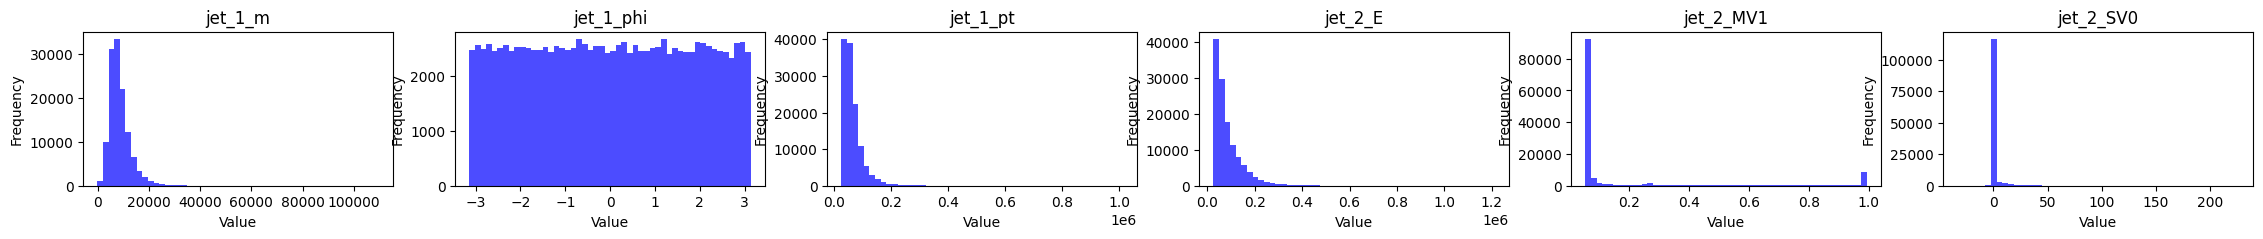

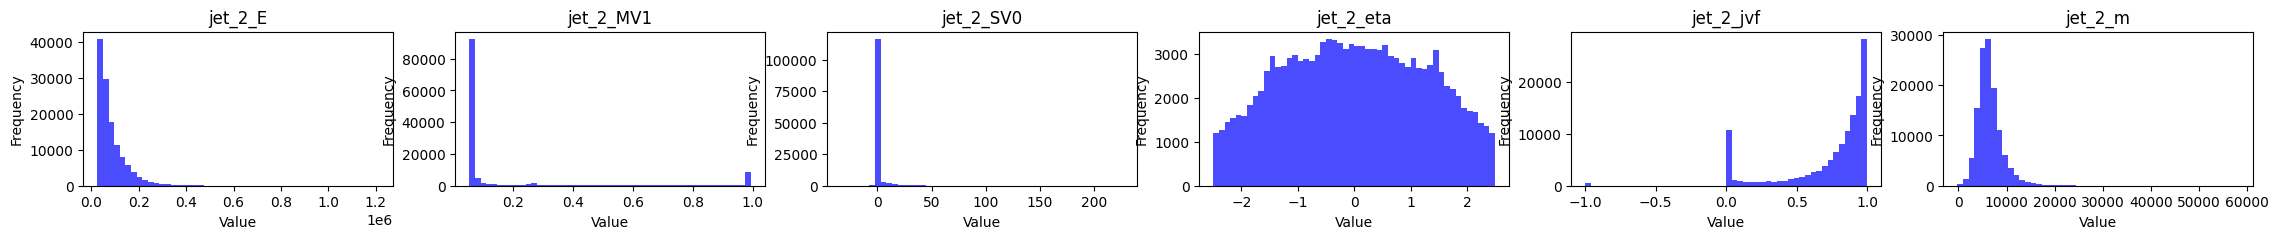

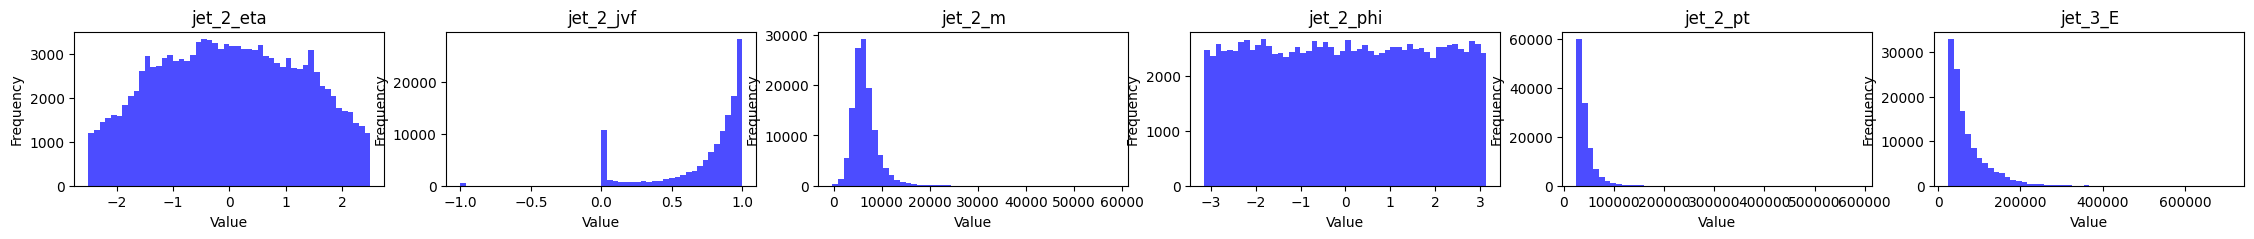

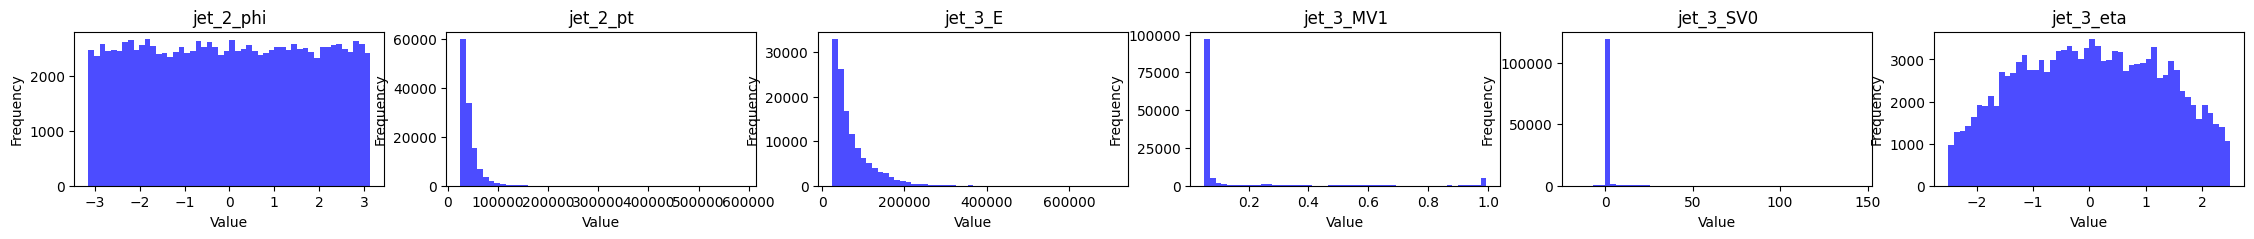

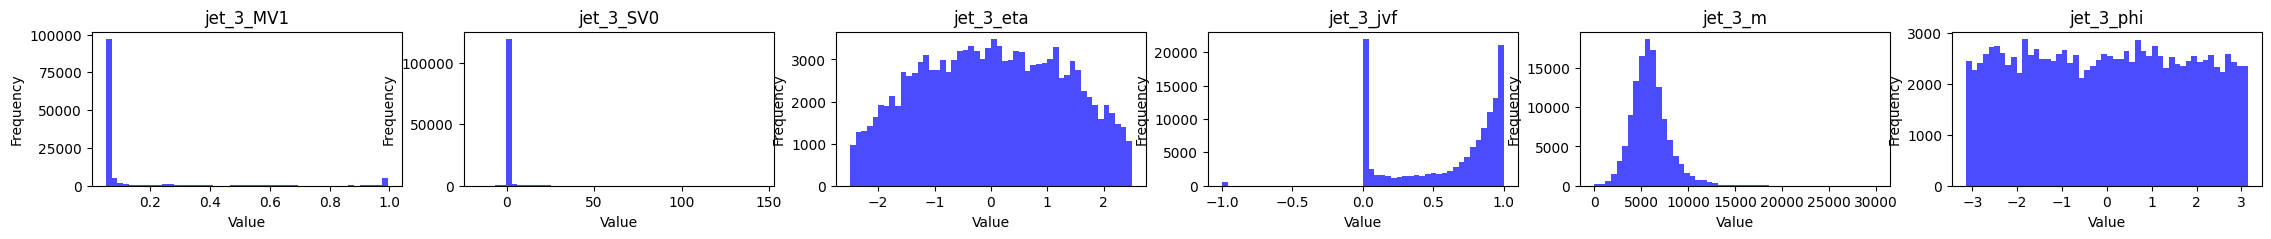

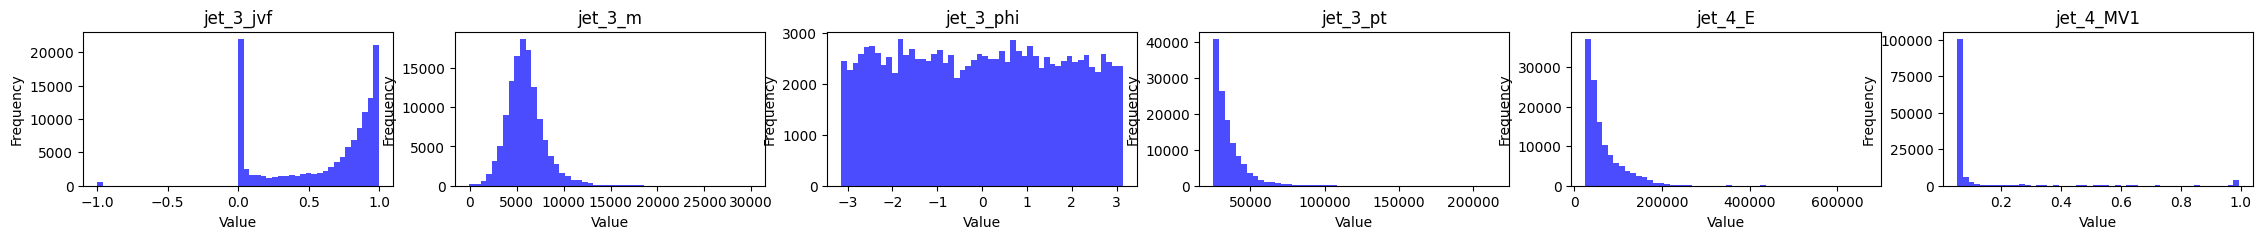

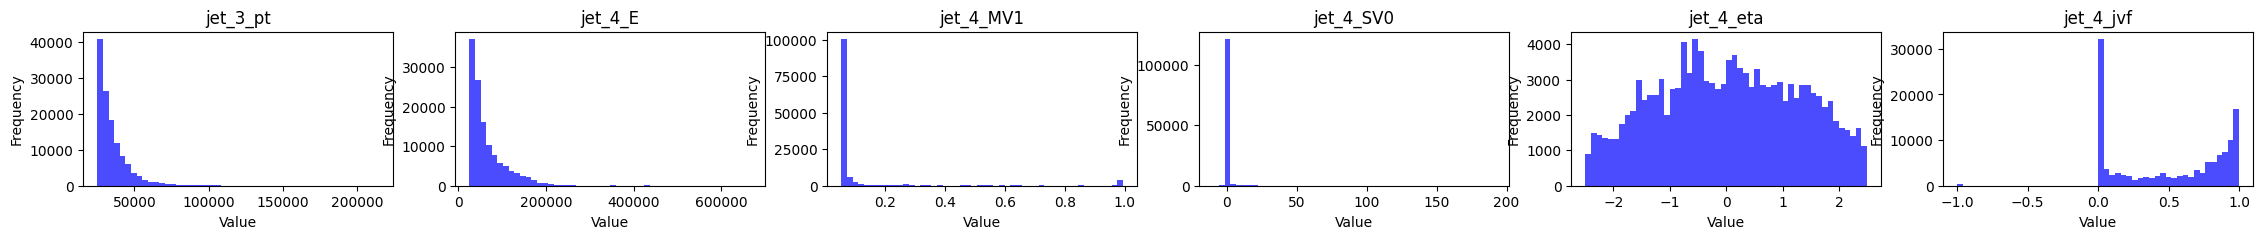

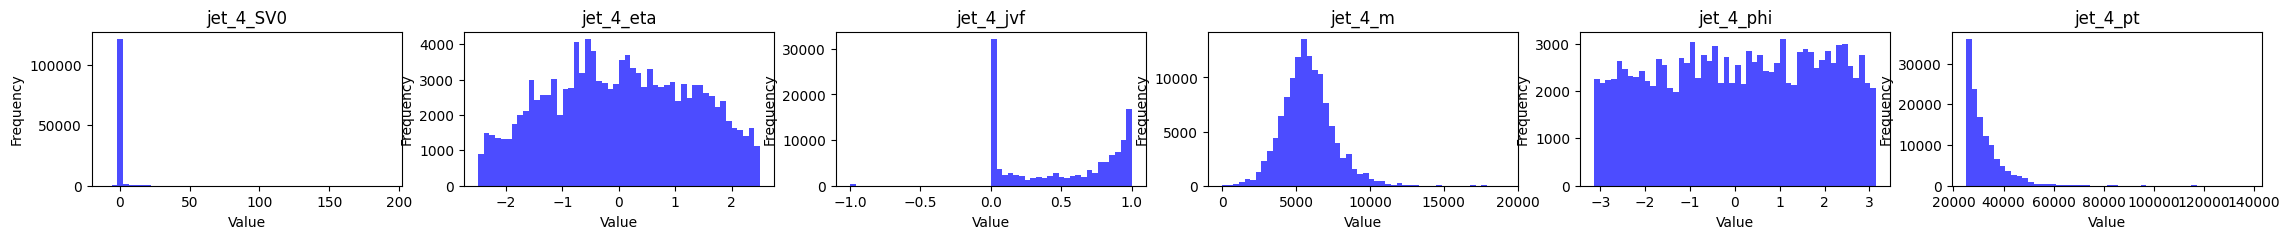

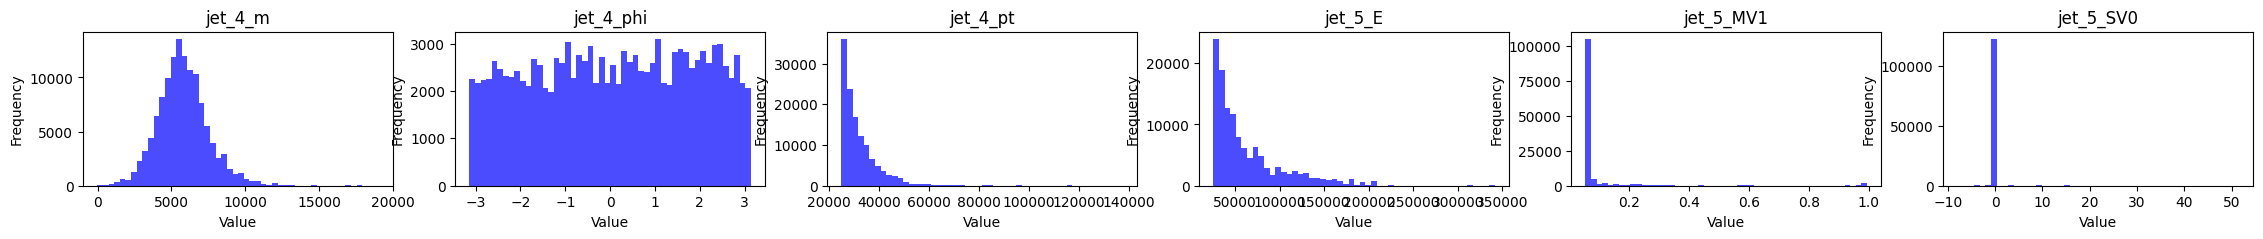

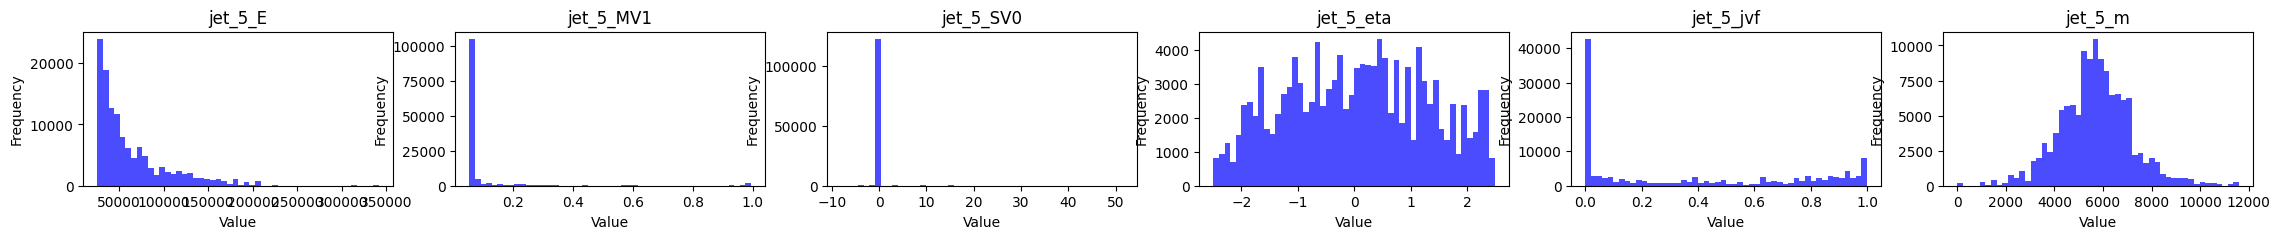

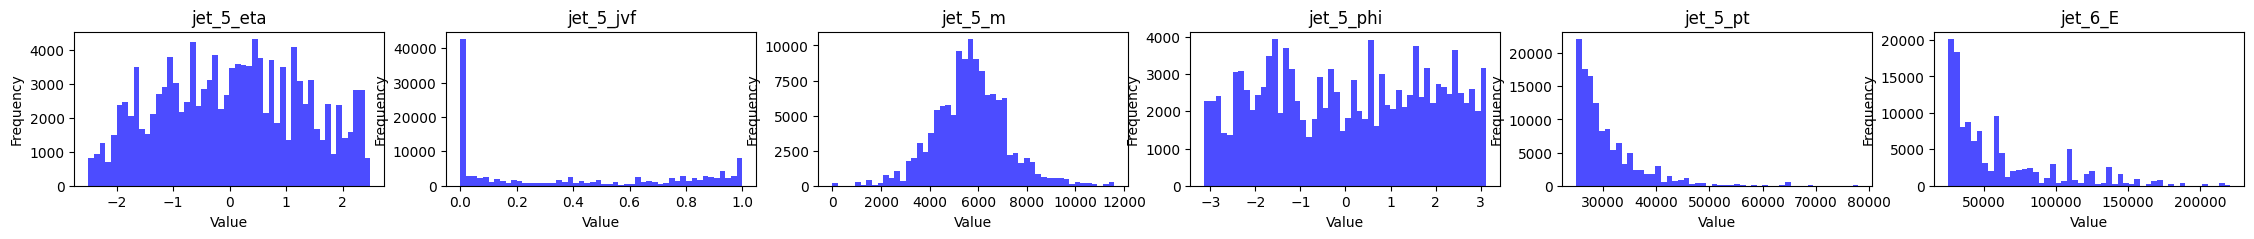

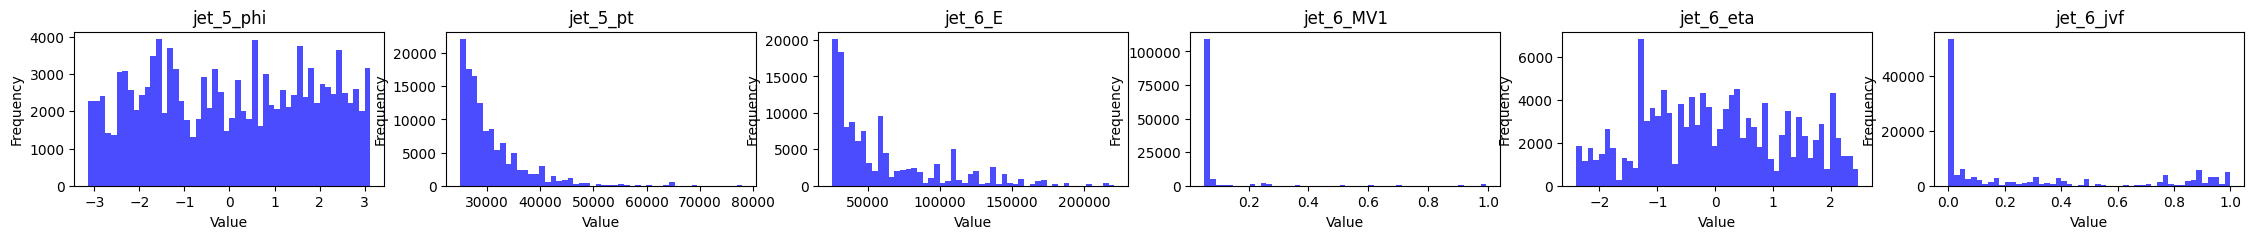

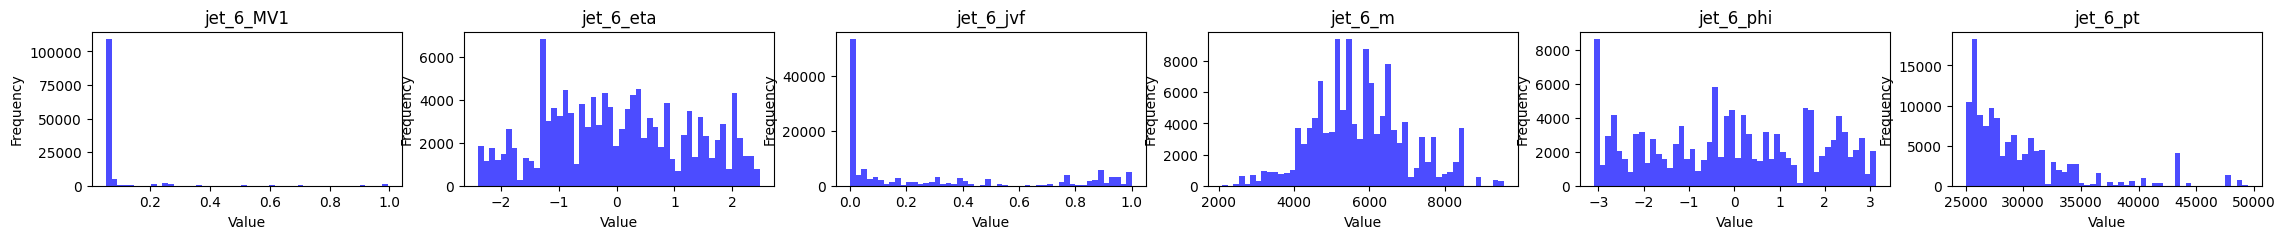

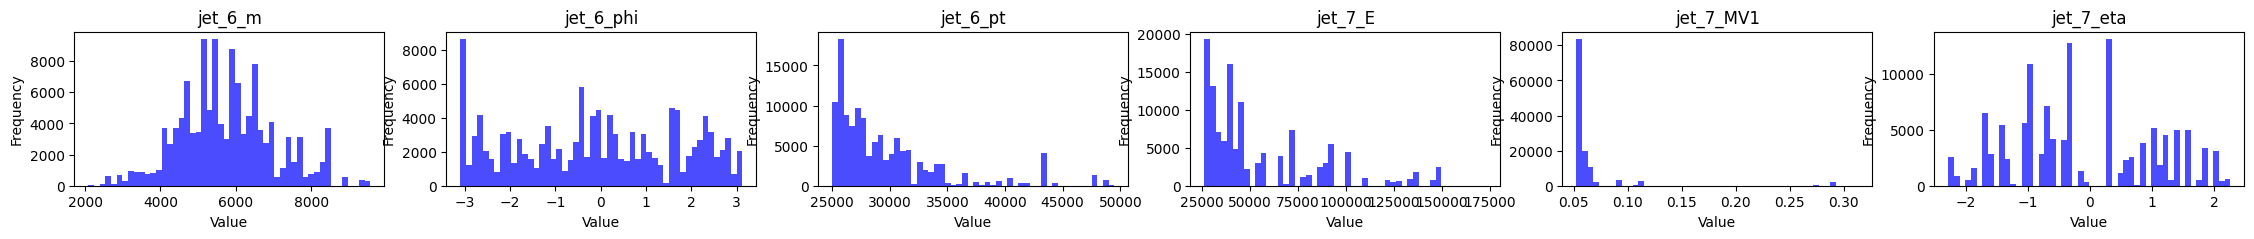

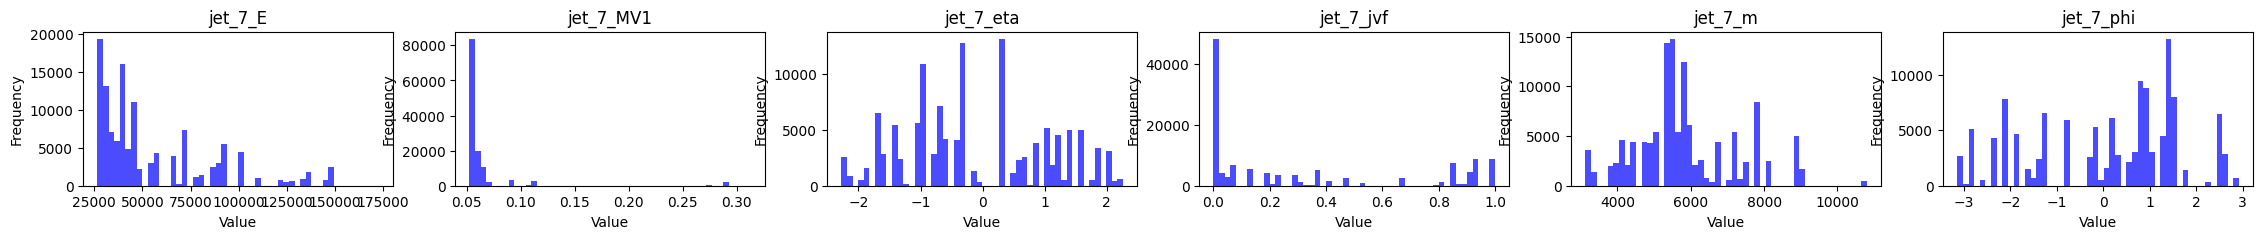

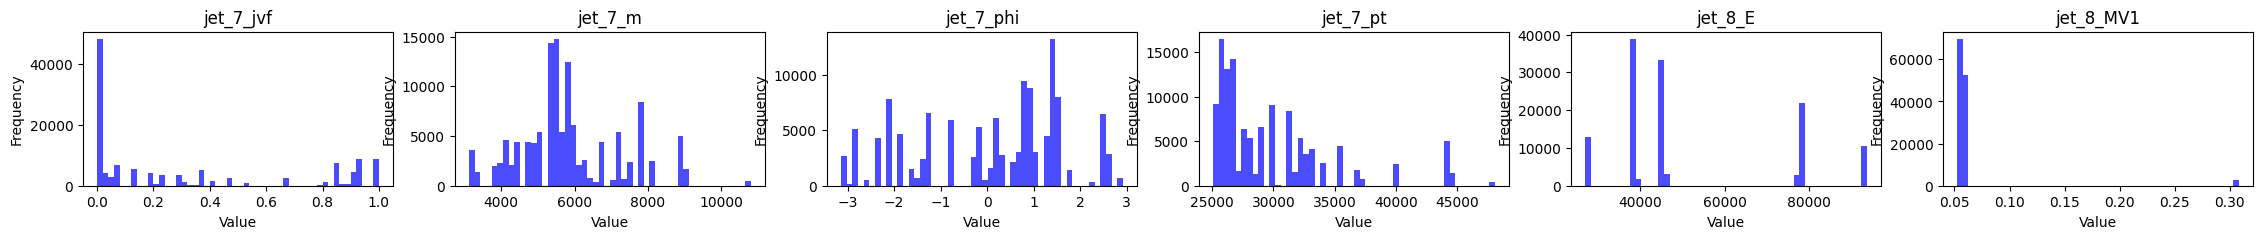

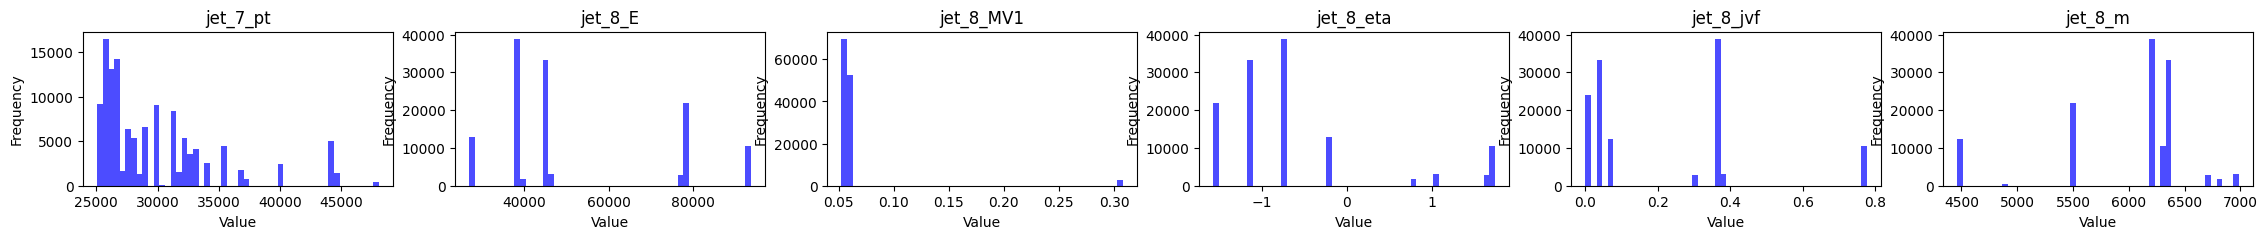

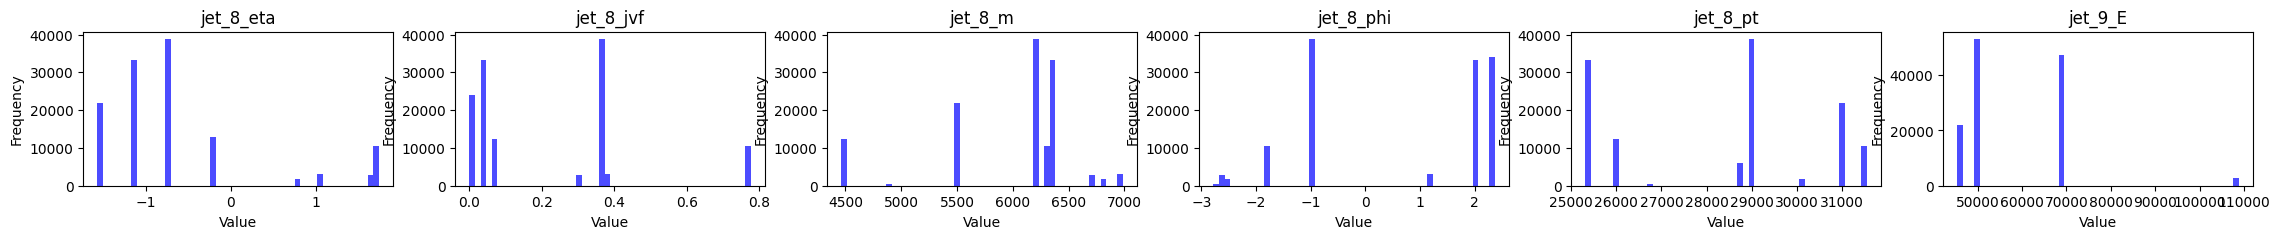

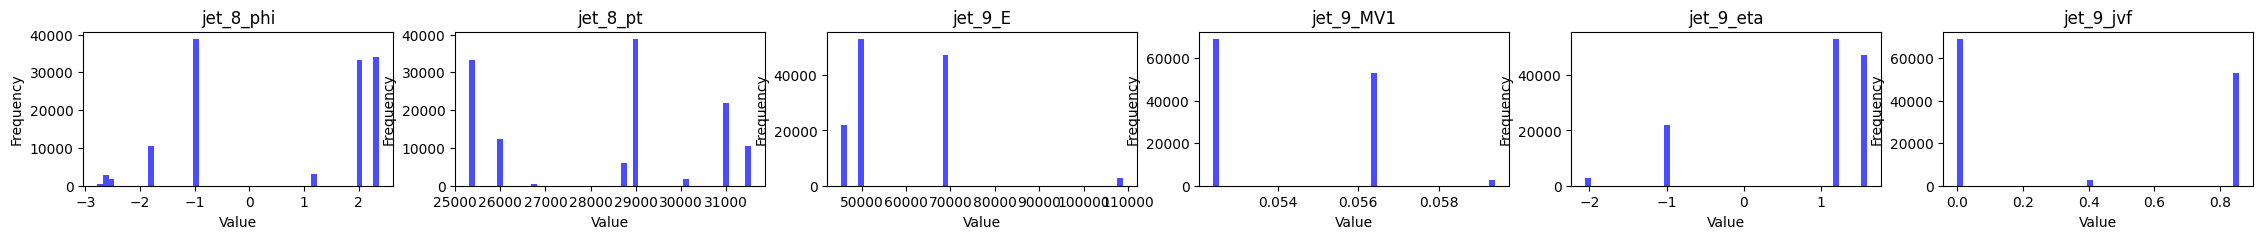

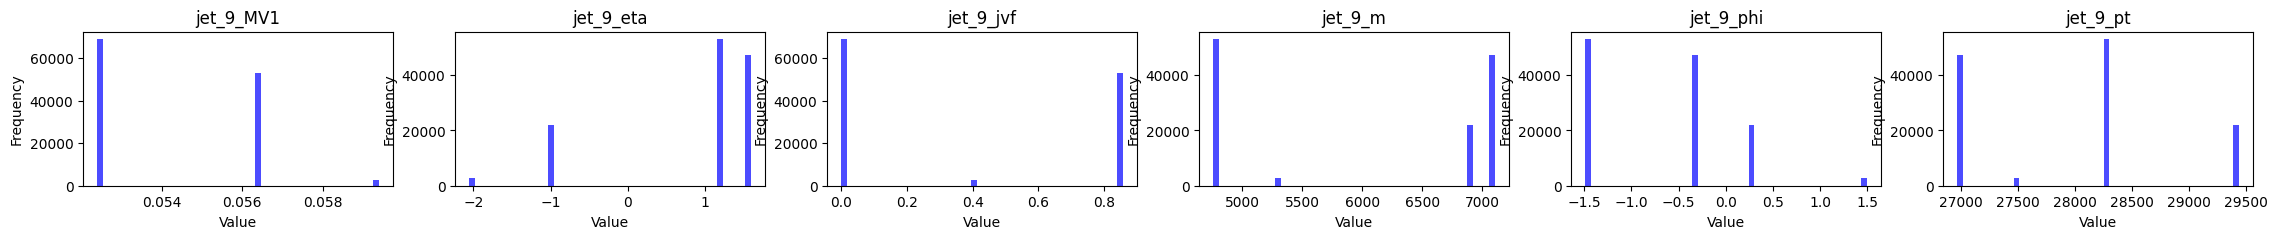

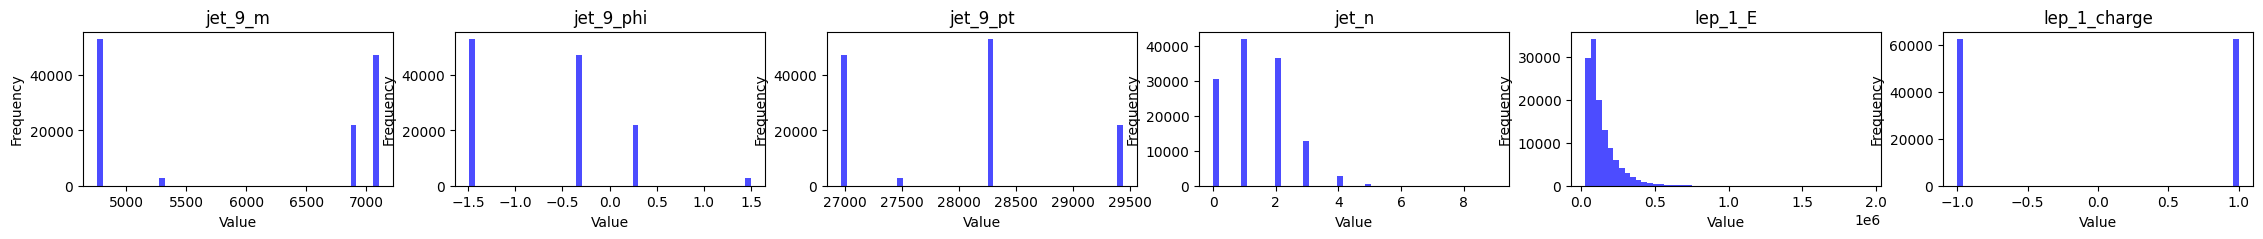

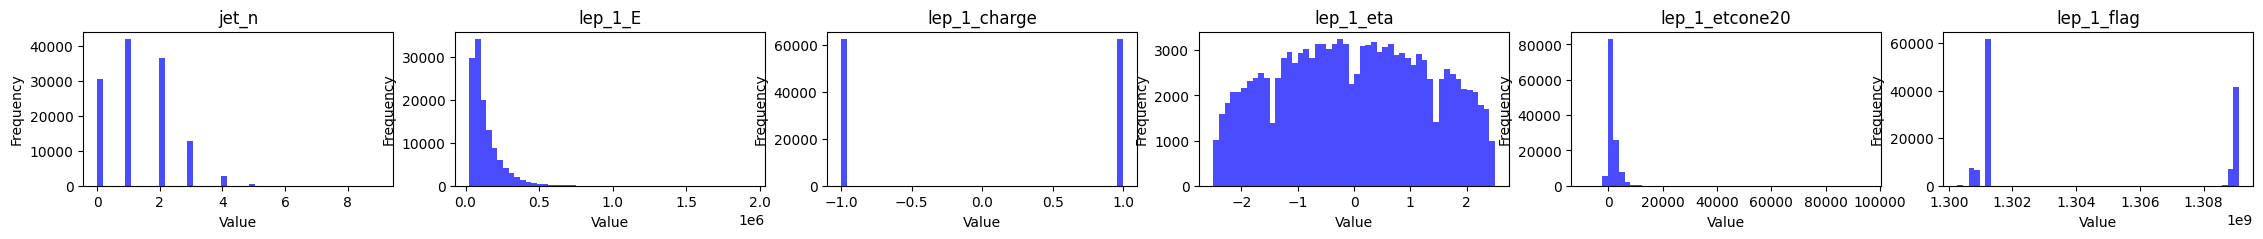

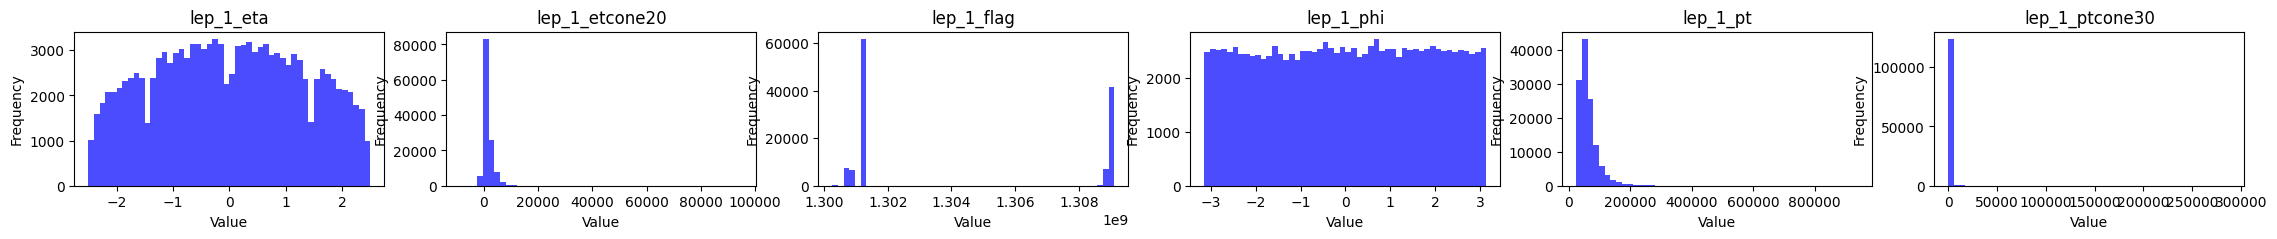

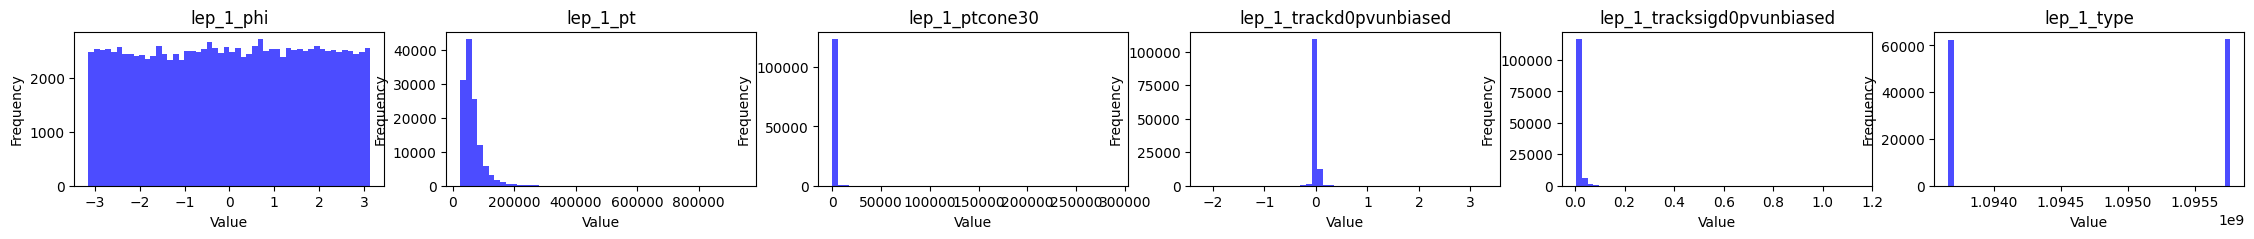

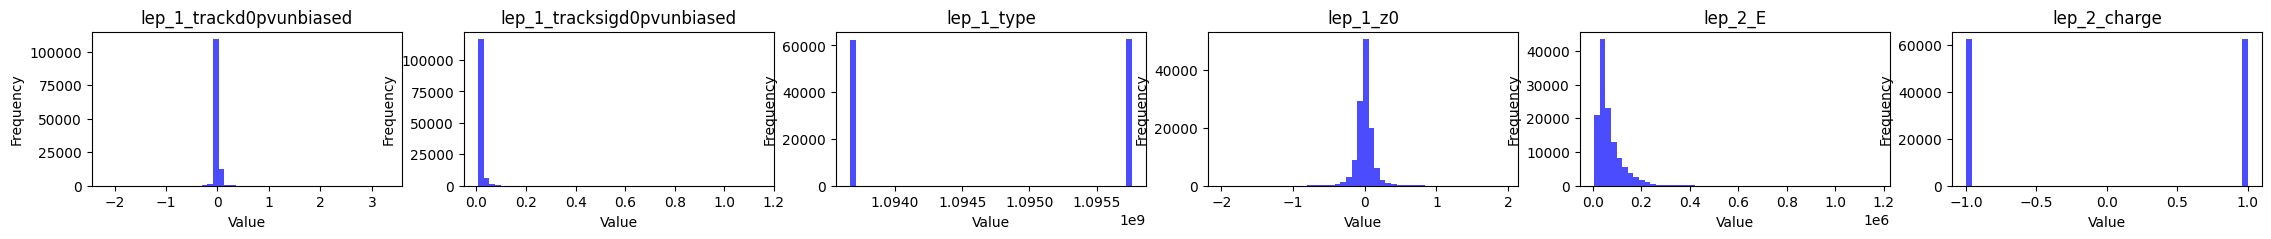

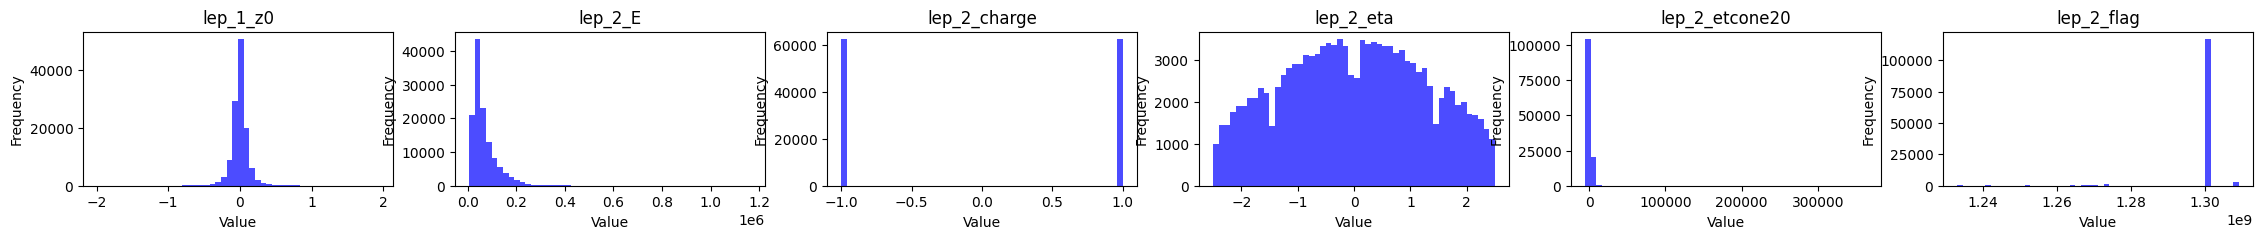

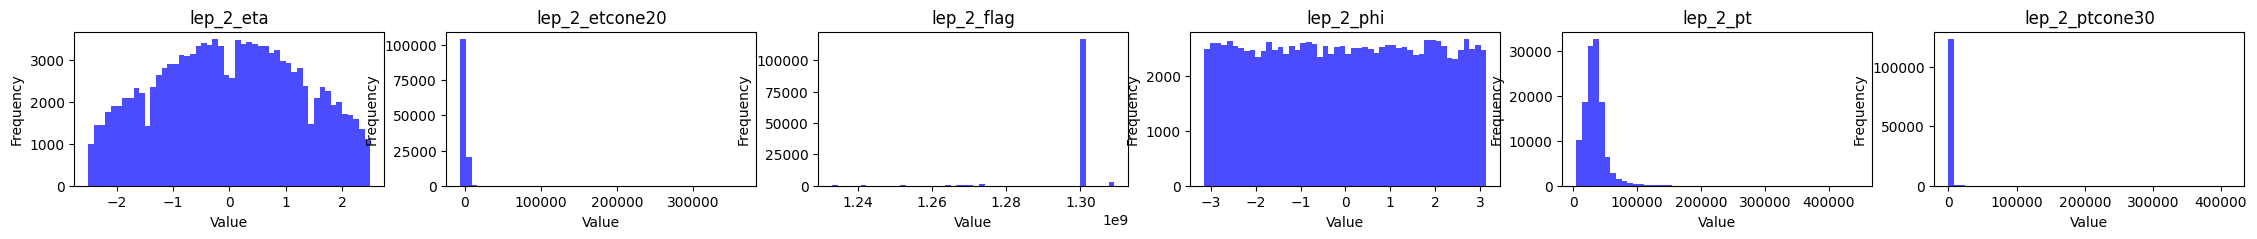

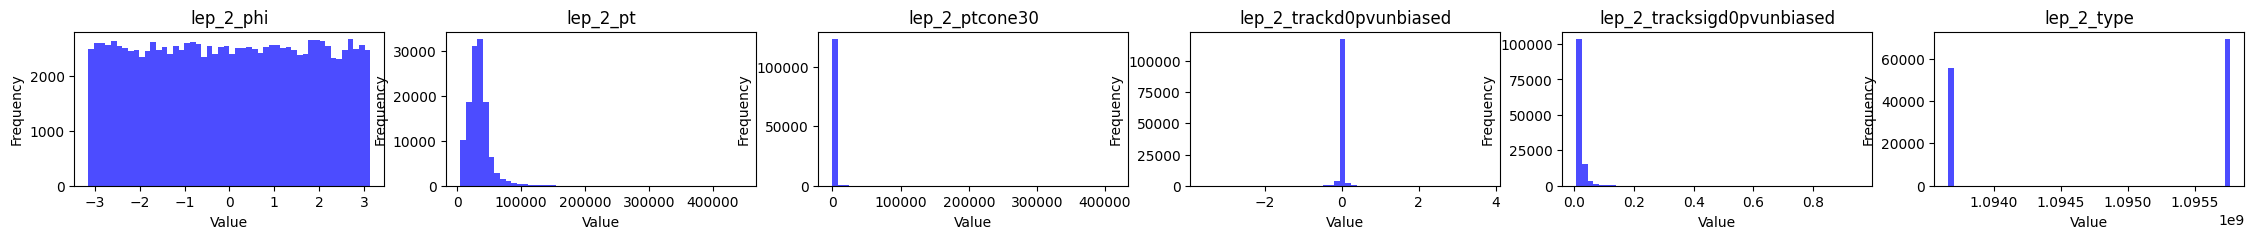

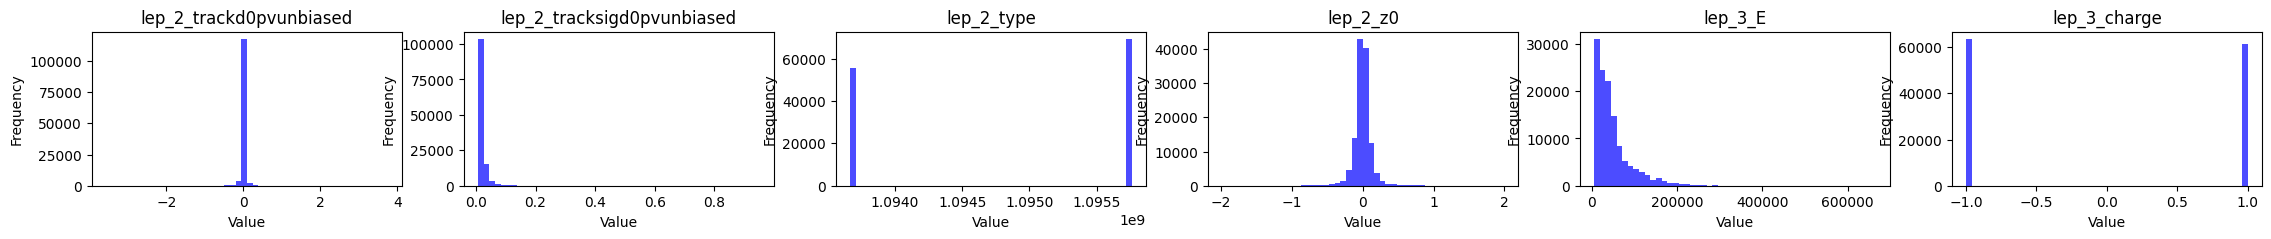

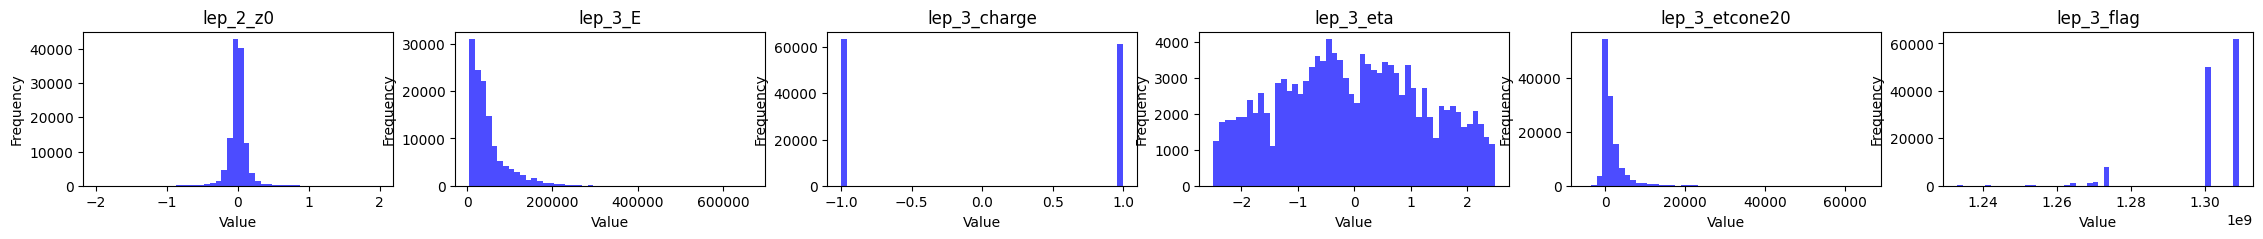

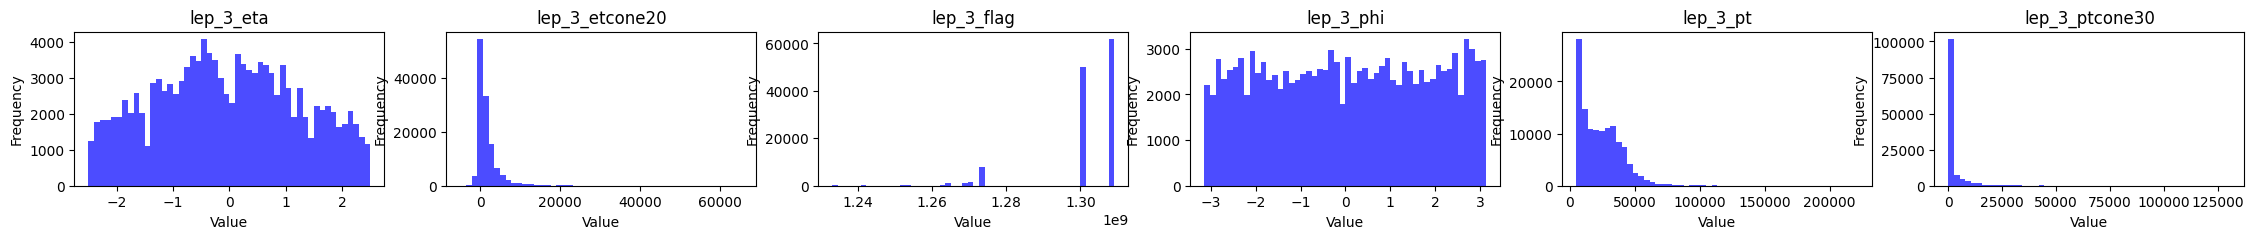

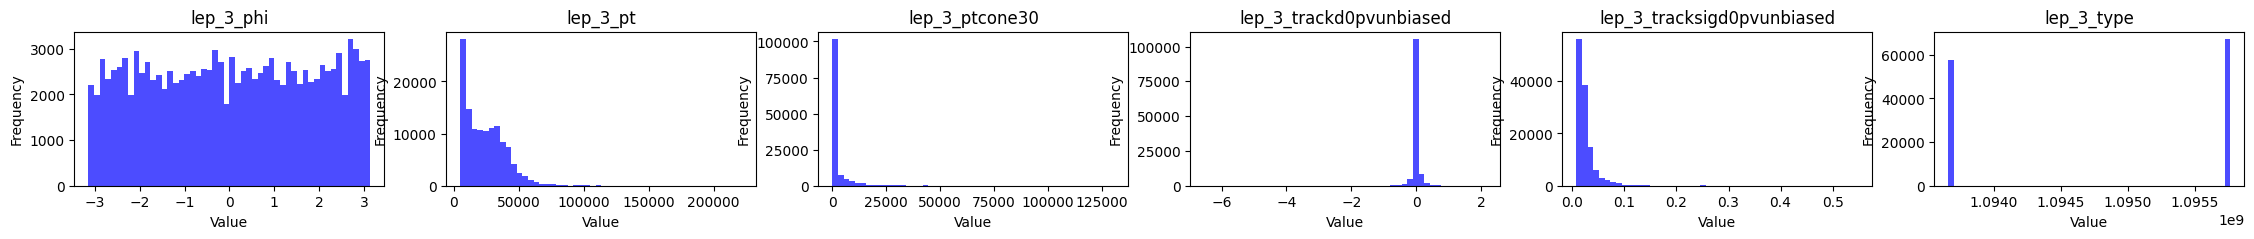

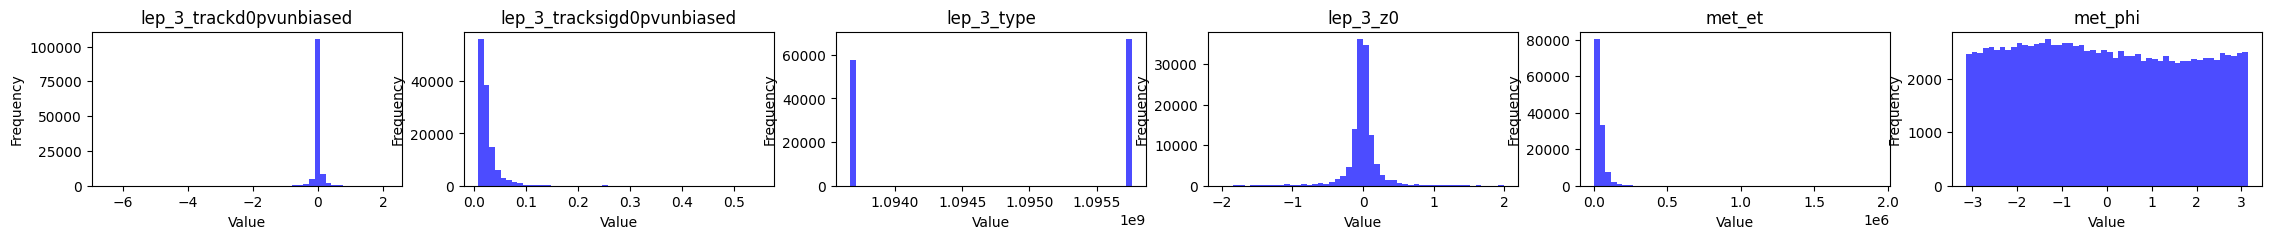

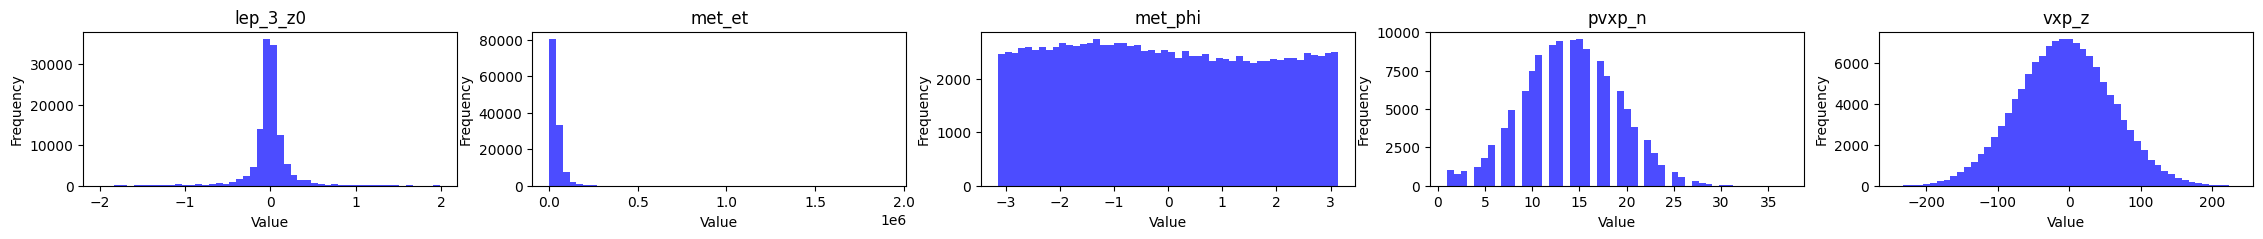

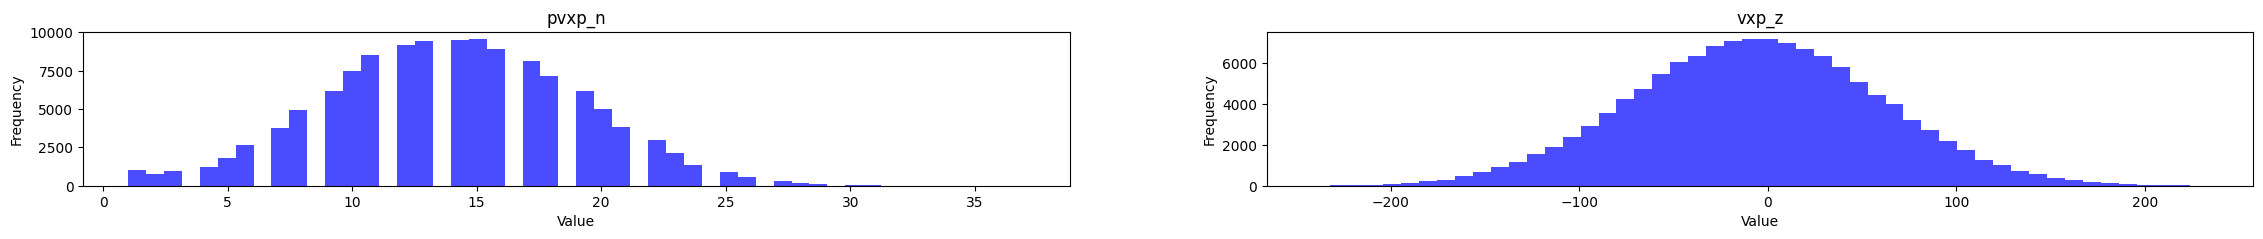

In [9]:
# Extract all features excluding the ones specified -> note: these are manully chosen initially because they are irrelevant for training our model.
# However, we still have to do a more refined feature validation as you will see further down
plot_features = [col for col in data.columns if col not in [
    'eventWeight', 
    'mcWeight', 
    'channelNumber', 
    'runNumber', 
    'data_type', 
    'label', 
    'eventNumber', 
    'jet_6_SV0', 
    'jet_7_SV0', 
    'jet_8_SV0', 
    'jet_9_SV0', 
    'jet_8_trueflav', 
    'jet_9_trueflav',
    'lep_4_E',                       
    'lep_4_charge',            
    'lep_4_eta',                     
    'lep_4_etcone20',                
    'lep_4_flag',                   
    'lep_4_phi',                     
    'lep_4_pt',                      
    'lep_4_ptcone30',                
    'lep_4_trackd0pvunbiased',       
    'lep_4_tracksigd0pvunbiased',    
    'lep_4_type',                   
    'lep_4_z0',                     
    'lep_5_E',                       
    'lep_5_charge',                  
    'lep_5_eta',                     
    'lep_5_etcone20',             
    'lep_5_flag',                    
    'lep_5_phi',                     
    'lep_5_pt',                      
    'lep_5_ptcone30',             
    'lep_5_trackd0pvunbiased',      
    'lep_5_tracksigd0pvunbiased',   
    'lep_5_type',                    
    'lep_5_z0',                                            
    'lep_trigMatched',      
    'jet_1_trueflav',                
    'jet_1_truthMatched',            
    'jet_2_trueflav',                
    'jet_2_truthMatched',            
    'jet_3_trueflav',                
    'jet_3_truthMatched',            
    'jet_4_trueflav',                
    'jet_4_truthMatched',            
    'jet_5_trueflav',                
    'jet_5_truthMatched',            
    'jet_6_trueflav',                
    'jet_6_truthMatched',            
    'jet_7_trueflav',                
    'jet_7_truthMatched',            
    'jet_8_trueflav',                
    'jet_8_truthMatched',            
    'jet_9_trueflav',                
    'jet_9_truthMatched',            
    'runNumber',                     
    'scaleFactor_BTAG',              
    'scaleFactor_ELE',               
    'scaleFactor_JVFSF',             
    'scaleFactor_MUON',              
    'scaleFactor_PILEUP',            
    'scaleFactor_TRIGGER',           
    'scaleFactor_ZVERTEX']]

# Create separate figures for each group of features
for i in range(0, len(plot_features), 3):
    # Determine the number of subplots needed
    n_subplots = min(6, len(plot_features) - i)
    fig, axs = plt.subplots(1, n_subplots, figsize=(28, 2))
    # If there's only one subplot, axs will not be an array, so we wrap it in one
    if n_subplots == 1:
        axs = [axs]
    for j in range(n_subplots):
        feature_name = plot_features[i+j]
        axs[j].hist(data[feature_name], bins=50, color='blue', alpha=0.7)
        axs[j].set_xlabel('Value')
        axs[j].set_ylabel('Frequency')
        axs[j].set_title(feature_name)
    plt.show()


### Feature Correlation

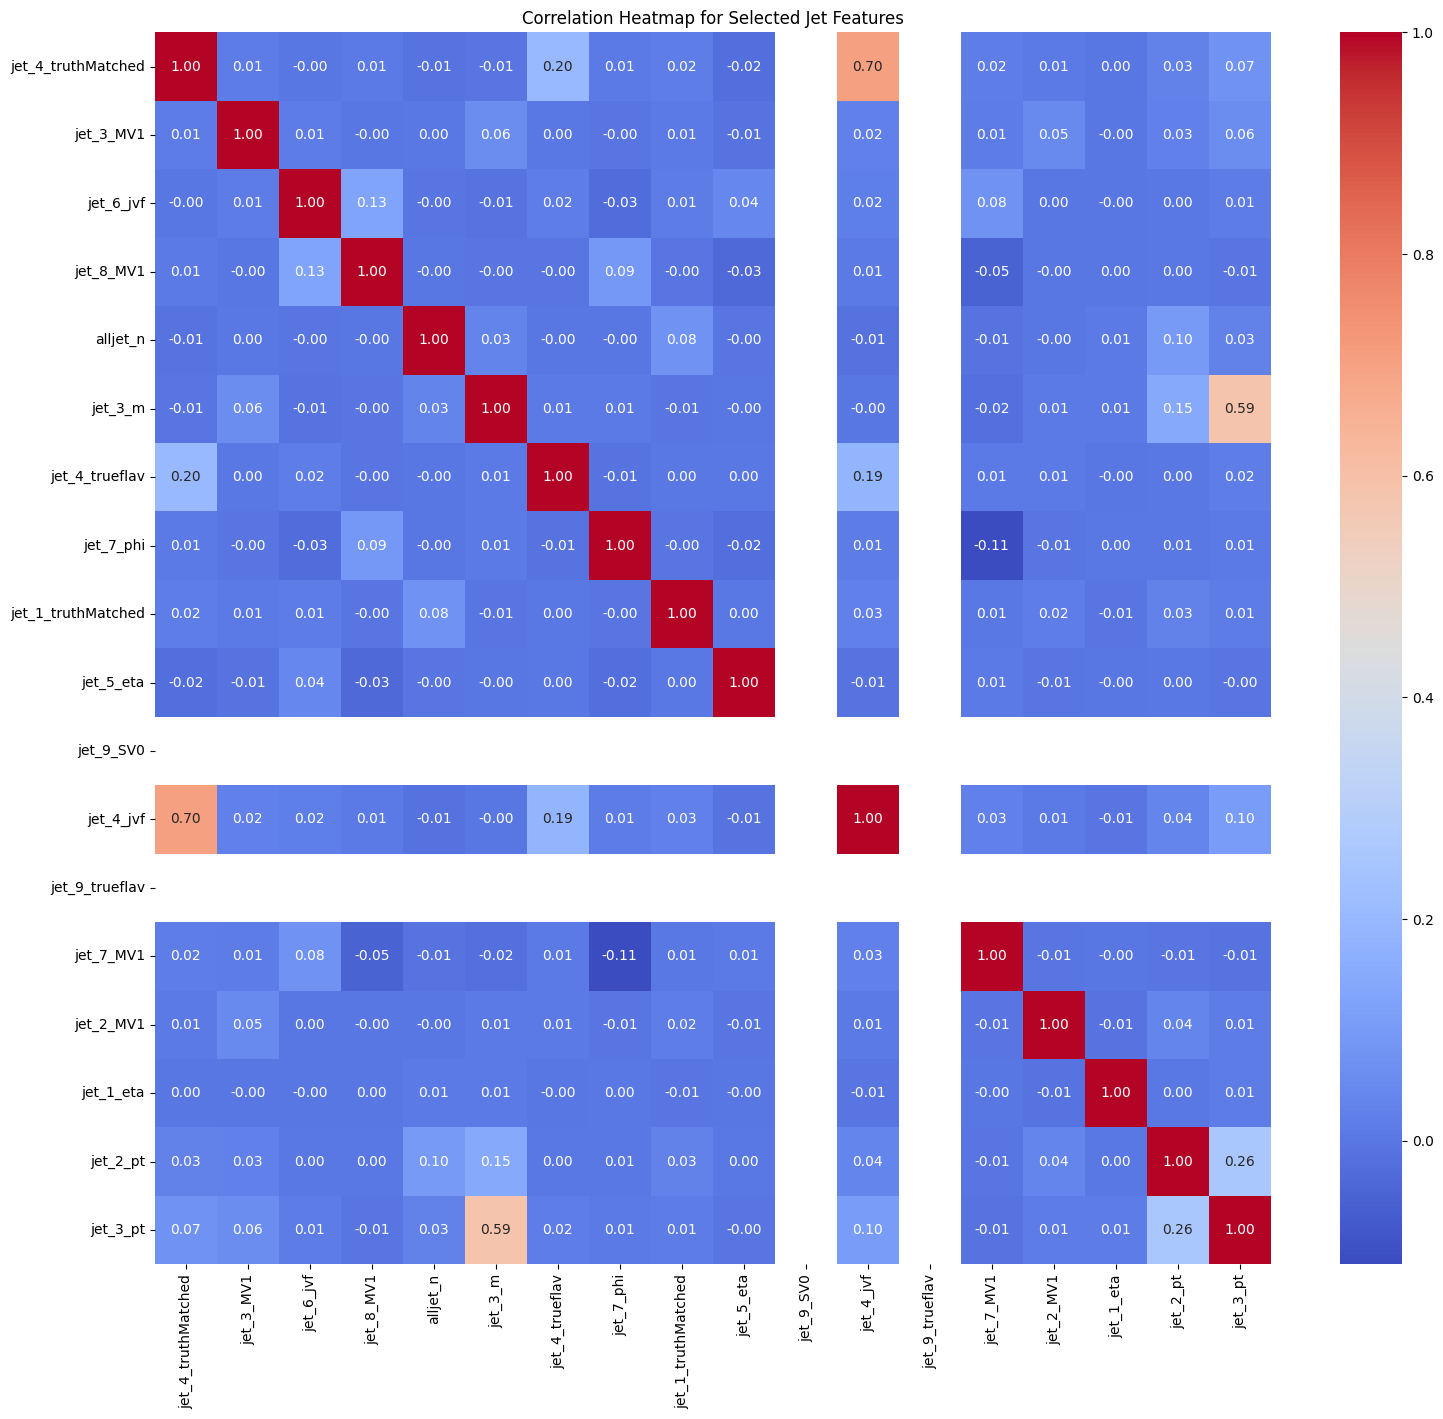

In [11]:
# For jet features, select a random percentage
jet_features = [col for col in data.columns if 'jet' in col]

np.random.seed(42)  # For reproducibility
half_jet_features = np.random.choice(jet_features, size=len(jet_features) // 5, replace=False) # Select the percentage here //
jet_data_half = data[half_jet_features]
jet_correlation_half = jet_data_half.corr()

plt.figure(figsize=(18, 16))
sns.heatmap(jet_correlation_half, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap for Selected Jet Features')
plt.show()

Here we can see that jet_9_SV0 and Jet_9_trueflav are blank. That indicates that they may have a constant value across all observations. This is confirmed when we watch the histograms above. These can be deleted from the features before training the model.

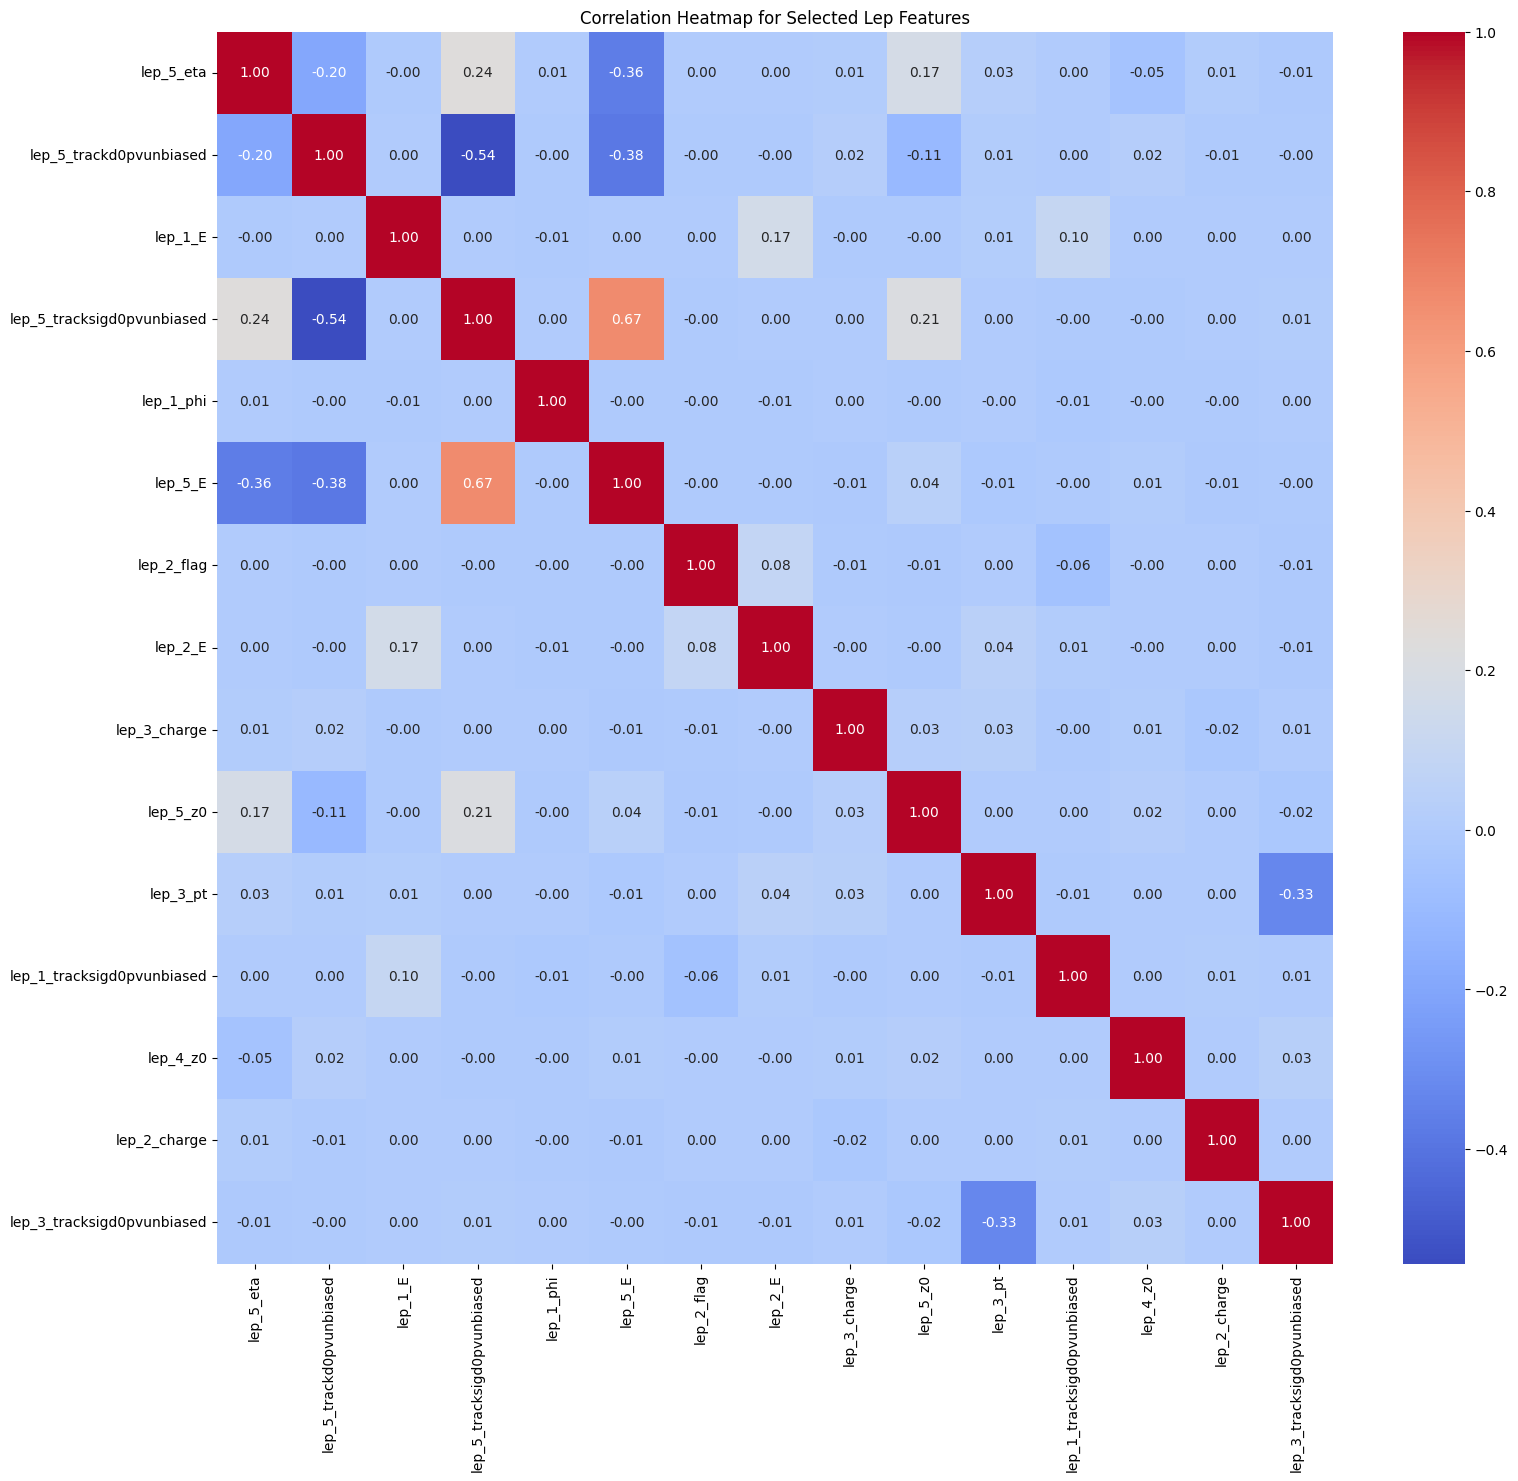

In [15]:
# For lep features, select a random percentage (due to fitting issues)
lep_features = [col for col in data.columns if 'lep' in col]

np.random.seed(fixed_seed)  # For reproducibility
half_lep_features = np.random.choice(lep_features, size=len(lep_features) // 4, replace=False) # Select the percentage here //
lep_data_half = data[half_lep_features]
lep_correlation_half = lep_data_half.corr()

plt.figure(figsize=(18, 16))
sns.heatmap(lep_correlation_half, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap for Selected Lep Features')
plt.show()

These heatmaps illustrates the correlation between various features in the dataset. The main diagonal, showing perfect correlation, represents each feature's correlation with itself. Off-diagonal bright spots indicate a high positive correlation between different features.

#### We inspected the histograms again and we found 6 features that offers no variability

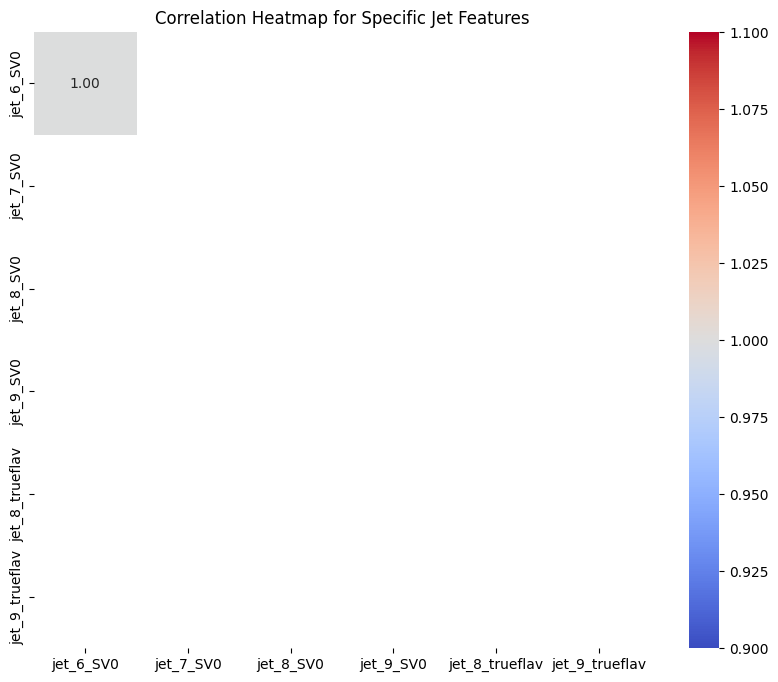

In [16]:
# List of specific features to plot
specific_features = ['jet_6_SV0', 'jet_7_SV0', 'jet_8_SV0', 'jet_9_SV0', 'jet_8_trueflav', 'jet_9_trueflav']

# Selecting the data for these specific features
specific_data = data[specific_features]

# Computing the correlation matrix
specific_correlation = specific_data.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(specific_correlation, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap for Specific Jet Features')
plt.show()


### Inspecting Background vs Signal events
##### Visualizing Data Volume: Background vs. Signal:

Total Background Data Length: 22442556
Total Signal Data Length: 163308
Signal to Background Ratio: 1:137


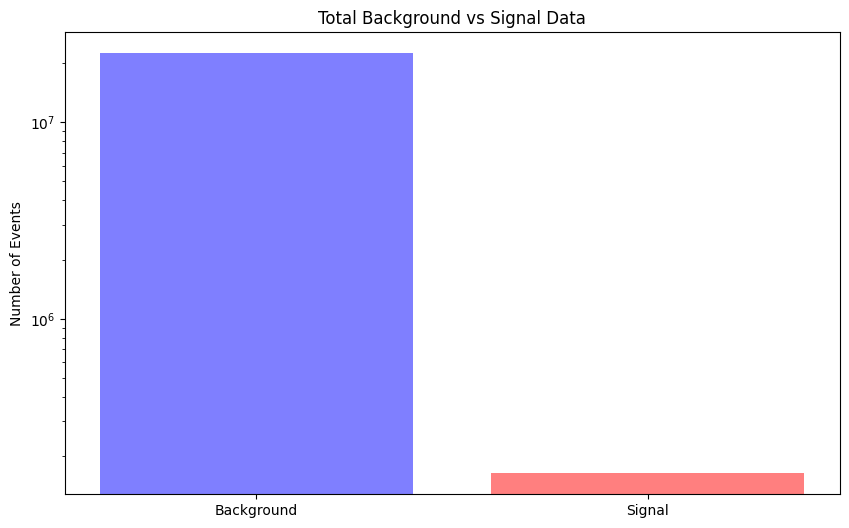

In [22]:
# Function to get dataset length without loading data
def get_dataset_length(file_path):
    with h5py.File(file_path, 'r') as file:
        length = len(file['mini'])
    return length

# Sum up the total lengths
total_background = sum(get_dataset_length(path + f) for f in background_files)
total_signal = sum(get_dataset_length(path + f) for f in signal_files)
print(f"Total Background Data Length: {total_background}")
print(f"Total Signal Data Length: {total_signal}")
print(f"Signal to Background Ratio: 1:{total_background // total_signal}")

# Define categories and totals
categories = ['Background', 'Signal']
totals = [total_background, total_signal]

# Data for plotting
plt.figure(figsize=(10, 6))
plt.bar(categories, totals, color=['blue', 'red'], alpha=0.5)

# Add labels and title
plt.ylabel('Number of Events')
plt.title('Total Background vs Signal Data')
plt.yscale('log')

# Show plot
plt.show()

As we can see, the dataset has significantly more background events than signal events, it's important to acknowledge this class imbalance as it can have an impact on model training and evaluation.

# Baseline model

### Feature Selection using Random forest
We will use a random forest model to train a subset of the data.
Then we will measure and rank the Feature Importance.
Those results will give us an indication of which features we should keep to have a good performing model,
but we need to manually check features as well before retraining the model on our newly chosen features. Once we update the features to be excluded, we can just run the cells under here again.

In [59]:
# Explicitly delete 'data' to free up memory
import gc
del data
gc.collect()  # Trigger garbage collection to free up memory

24734

### Define Data Subset Loading Function 

In [60]:
def load_subset_data(file_list, label, subset_percentage):
    df_combined = pd.DataFrame()
    for file in file_list:
        with h5py.File(path + file, 'r') as f:
            data = f['mini'][:]
        
        # Determine the subset size based on the percentage
        subset_size = int(len(data) * subset_percentage)
        
        # Take a random subset of data
        np.random.shuffle(data)
        data = data[:subset_size]
        
        data_df = pd.DataFrame(data)
        data_df['label'] = label
        df_combined = pd.concat([df_combined, data_df], ignore_index=True)

    return df_combined

### Load Data Subset

In [61]:
# Load a subset of background and signal data - set the percentage here
subset_percentage = 0.1
df_background = load_subset_data(background_files, 0, subset_percentage)
df_signal = load_subset_data(signal_files, 1, subset_percentage)

### Combine and Shuffle Data

In [62]:
# Combine background and signal data
df_combined = pd.concat([df_background, df_signal])

# Shuffle the combined DataFrame
df_combined = shuffle(df_combined, random_state=fixed_seed)

### Define features and Labels

In [63]:
# Define features to exclude from the model - note: these are manully chosen after doing data analyzing of histograms and correlation matrixes.
# As we find more features to exlcude, we manually add them here.
excluded_features = [
    'eventWeight', 
    'mcWeight', 
    'channelNumber', 
    'runNumber', 
    'data_type', 
    'label', 
    'eventNumber', 
    'jet_6_SV0', 
    'jet_7_SV0', 
    'jet_8_SV0', 
    'jet_9_SV0', 
    'jet_8_trueflav', 
    'jet_9_trueflav',
    'lep_4_E',                       
    'lep_4_charge',            
    'lep_4_eta',                     
    'lep_4_etcone20',                
    'lep_4_flag',                   
    'lep_4_phi',                     
    'lep_4_pt',                      
    'lep_4_ptcone30',                
    'lep_4_trackd0pvunbiased',       
    'lep_4_tracksigd0pvunbiased',    
    'lep_4_type',                   
    'lep_4_z0',                     
    'lep_5_E',                       
    'lep_5_charge',                  
    'lep_5_eta',                     
    'lep_5_etcone20',             
    'lep_5_flag',                    
    'lep_5_phi',                     
    'lep_5_pt',                      
    'lep_5_ptcone30',             
    'lep_5_trackd0pvunbiased',      
    'lep_5_tracksigd0pvunbiased',   
    'lep_5_type',                    
    'lep_5_z0',                                             
    'lep_trigMatched',      
    'jet_1_trueflav',                
    'jet_1_truthMatched',            
    'jet_2_trueflav',                
    'jet_2_truthMatched',            
    'jet_3_trueflav',                
    'jet_3_truthMatched',            
    'jet_4_trueflav',                
    'jet_4_truthMatched',            
    'jet_5_trueflav',                
    'jet_5_truthMatched',            
    'jet_6_trueflav',                
    'jet_6_truthMatched',            
    'jet_7_trueflav',                
    'jet_7_truthMatched',            
    'jet_8_trueflav',                
    'jet_8_truthMatched',            
    'jet_9_trueflav',                
    'jet_9_truthMatched',            
    'runNumber',                     
    'scaleFactor_BTAG',              
    'scaleFactor_ELE',               
    'scaleFactor_JVFSF',             
    'scaleFactor_MUON',              
    'scaleFactor_PILEUP',            
    'scaleFactor_TRIGGER',           
    'scaleFactor_ZVERTEX'
] 

In [64]:
# Select features for training the model
features = [col for col in df_combined.columns if col not in excluded_features]

### Prepare Data for Training

In [65]:
# Prepare the feature matrix (X) and the target vector (y)
X = df_combined[features]
y = df_combined['label']

# Split the data into training and test sets using a 60-40 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=fixed_seed)

### Train the first Random Forest Classifier - Baseline Model

In [66]:
# Initialize the RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=fixed_seed)

# Start the timer
start_time = time.time()

# Train the model on the training data
rf_clf.fit(X_train, y_train)

# Calculate the training time
end_time = time.time()
training_time = end_time - start_time

# Calculate hours, minutes, and seconds
hours = int(training_time // 3600)
minutes = int((training_time % 3600) // 60)
seconds = int(training_time % 60)

# Format the training time
formatted_training_time = f"Time: {hours} hours, {minutes} minutes, {seconds} seconds"
print(formatted_training_time)

Time: 1 hours, 24 minutes, 25 seconds


### Rank the feature importance

In [67]:
pd.set_option('display.max_rows', None) # Option to show all features
# Get feature importance scores
feature_importance = rf_clf.feature_importances_

# Create a Series with feature importance scores, indexed by feature names
feature_importance_series = pd.Series(feature_importance, index=X_train.columns)

# Sort the features by their importance scores in descending order
sorted_features = feature_importance_series.sort_values(ascending=False)

# Print the sorted features with their importance scores
print("Features ranked by importance:")
print(sorted_features)

Features ranked by importance:
met_et                        0.070593
jet_1_m                       0.063778
jet_1_pt                      0.062007
lep_1_pt                      0.041299
lep_2_pt                      0.028831
jet_2_pt                      0.027049
jet_1_E                       0.024804
jet_3_pt                      0.018925
lep_1_tracksigd0pvunbiased    0.018445
jet_n                         0.016941
lep_2_tracksigd0pvunbiased    0.014950
jet_2_m                       0.014940
alljet_n                      0.013538
lep_1_E                       0.013192
jet_4_pt                      0.011798
jet_5_pt                      0.011007
jet_3_m                       0.010774
lep_2_E                       0.010639
lep_1_etcone20                0.010432
jet_1_MV1                     0.009905
jet_2_E                       0.009655
jet_6_pt                      0.009406
jet_9_pt                      0.009136
jet_7_pt                      0.008625
jet_9_phi                     0.0

### Evaluate the model on all the features above

Test Accuracy: 0.9951937219790452


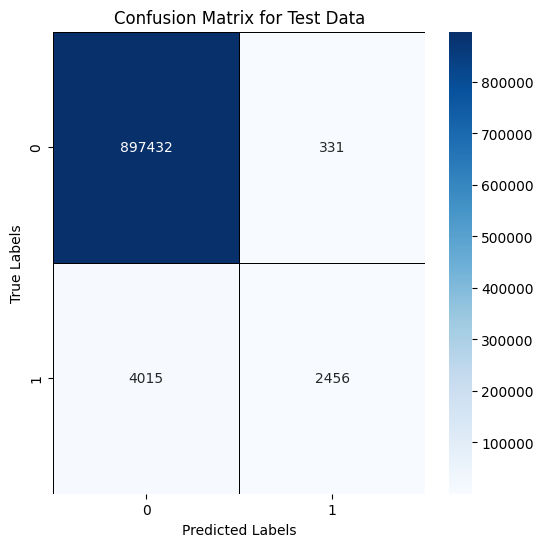

In [68]:
# Predict on the test set
y_pred_test = rf_clf.predict(X_test)
y_probs_test = rf_clf.predict_proba(X_test)[:, 1]  # Probability estimates for ROC curve on test data

# Calculate accuracy on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {accuracy_test}")

# Generate a confusion matrix for the test set predictions
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

# Plot the confusion matrix with custom formatting for the test data
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', linewidths=0.5, linecolor='black')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Test Data')
plt.show()


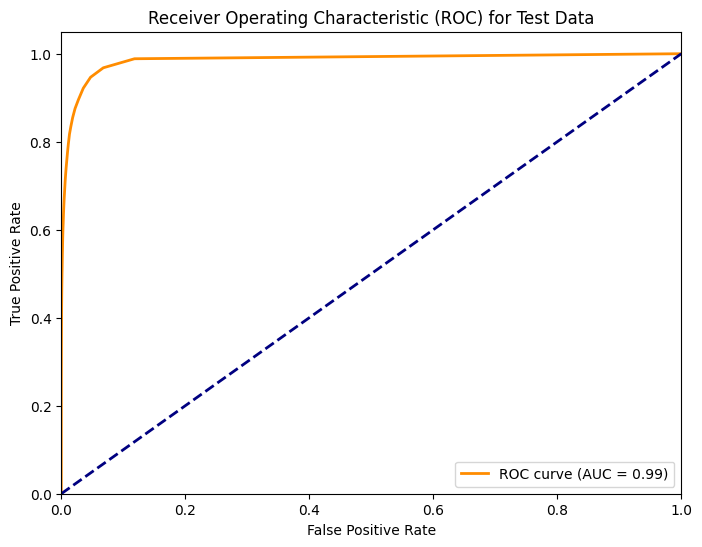

In [69]:
# Calculate the ROC curve for the test set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_probs_test)

# Calculate the AUC (Area Under the Curve) for the test set
roc_auc_test = auc(fpr_test, tpr_test)

# Plot the ROC curve for the test set
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Test Data')
plt.legend(loc='lower right')
plt.show()

In [70]:
# Evaluate the model
precision_rf = precision_score(y_test, y_pred_test)
recall_rf = recall_score(y_test, y_pred_test)
f1_score_rf = f1_score(y_test, y_pred_test)

print(f"Precision on Signal Test Data: {precision_rf:.4f}")
print(f"Recall on Signal Test Data: {recall_rf:.4f}")
print(f"F1-Score on Signal Test Data: {f1_score_rf:.4f}")

Precision on Signal Test Data: 0.8812
Recall on Signal Test Data: 0.3795
F1-Score on Signal Test Data: 0.5306


Precision on Signal Test Data: This suggests that among all instances predicted as signal (Zprime events), approximately 87% are actually signal events. In other words, when the model predicts a Zprime event, it is correct about 87% of the time. (Note. These values may vary slightly in case of a re-run of training. The correct final values are visible above.)

Recall on Signal Test Data: This indicates that the model identified approximately 38% of all actual signal events (Zprime events). It means that the model captures around 38% of the Zprime events present in the dataset.

F1-Score on Signal Test Data: The F1-score is the harmonic mean of precision and recall. It provides a balanced measure of the model's performance in terms of both precision and recall for the signal class (Zprime events). A higher F1-score indicates better overall performance, balancing both precision and recall

Conclusion. This model is kind of sceptic to evaluate the signal files. However, when it chooses to predict a signal file, it has a good accuracy, but because of its sceptic nature, the model will then miss many of the Zprime events. This is most likely due to the large imbalance of the datasets. We know that we have a lot more background than signal files. Next step will be to balance the datasets and train a new model in hope that the model will be less biased.

## Balancing the datasets
Now, we will try to balance the datasets as we know that there are many more background files than signal files.

# Undersampling

In [ ]:
# Delete variables to free up memory
del fpr_test, tpr_test, roc_auc_test, conf_matrix_test, X_test, y_probs_test, y_pred_test

# Call garbage collection
gc.collect()

In this step, we're balancing our dataset using a undersampled technique. We first load all signal data into a single DataFrame, then we count the entries and multiply the number of signal files with a desired ratio (background_to_signal_ratio). This way we take advantage of dealing with the imbalance, but also add some additiional background to make the model work better on heavily imbalanced datasets as well.

In [26]:
# Define the background to signal ratio
background_to_signal_ratio = 10  # 10 will give 10 times more background than signal data

# Load all signal data
df_signal_list = []
for file in signal_files:
    with h5py.File(f"{path}/{file}", 'r') as f:
        data = pd.DataFrame(f['mini'][:])
        data['label'] = 1  # Signal label
    df_signal_list.append(data)
df_signal = pd.concat(df_signal_list, ignore_index=True)

# Determine the total number of background entries needed
total_signal_entries = len(df_signal)
background_entries_needed = total_signal_entries * background_to_signal_ratio

# Calculate how many background entries to load per file
background_entries_per_file = background_entries_needed // len(background_files)

# Load a balanced subset of background data
df_background_list = []
for file in background_files:
    with h5py.File(f"{path}/{file}", 'r') as f:
        data = pd.DataFrame(f['mini'][:])
        if len(data) > background_entries_per_file:
            sampled_data = data.sample(n=background_entries_per_file, random_state=fixed_seed)
        else:
            sampled_data = data  # Use all data if the file contains less data than required
        sampled_data['label'] = 0  # Background label
    df_background_list.append(sampled_data)
df_background = pd.concat(df_background_list, ignore_index=True)

In [37]:
# Combine signal and background data
df_balanced = pd.concat([df_signal, df_background], ignore_index=True)

# Shuffle the combined DataFrame
df_balanced = shuffle(df_balanced, random_state=fixed_seed).reset_index(drop=True)

In [38]:
# Count the number of signal and background entries
signal_count = df_balanced[df_balanced['label'] == 1].shape[0]
background_count = df_balanced[df_balanced['label'] == 0].shape[0]

print(f"Number of signal entries: {signal_count}")
print(f"Number of background entries: {background_count}")

Number of signal entries: 163308
Number of background entries: 1455674


In [40]:
# Select features for training the model (Same features as the other models)
features = [col for col in df_balanced.columns if col not in excluded_features]

In [41]:
# Prepare the feature matrix (X) and the target vector (y)
X = df_balanced[features]
y = df_balanced['label']

### Prepare for training

In [42]:
# Split the data into training and test sets using a 60-40 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=fixed_seed)

# Initialize the RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=fixed_seed)

### Train the balanced dataset

In [43]:
# Initialize the RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=fixed_seed)

# Start the timer
start_time = time.time()

# Train the model on the training data
rf_clf.fit(X_train, y_train)

# Calculate the training time
end_time = time.time()
training_time = end_time - start_time

# Calculate hours, minutes, and seconds
hours = int(training_time // 3600)
minutes = int((training_time % 3600) // 60)
seconds = int(training_time % 60)

# Format the training time
formatted_training_time = f"Time: {hours} hours, {minutes} minutes, {seconds} seconds"
print(formatted_training_time)

Time: 0 hours, 52 minutes, 21 seconds


### Evaluate the model

Test Accuracy: 0.9661731982896665


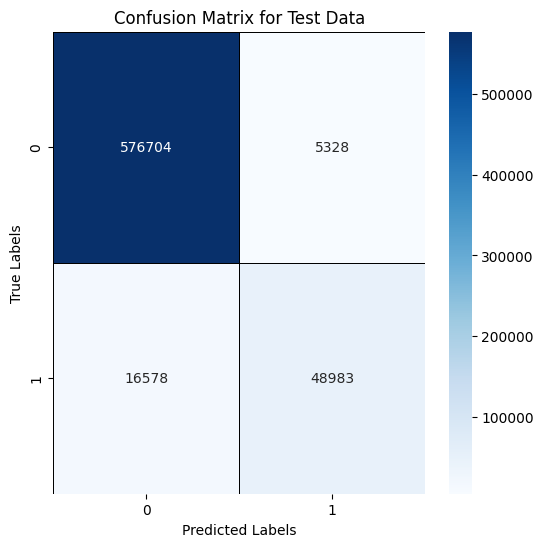

In [44]:
# Predict on the test set
y_pred_test = rf_clf.predict(X_test)
y_probs_test = rf_clf.predict_proba(X_test)[:, 1]  # Probability estimates for ROC curve on test data

# Calculate accuracy on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {accuracy_test}")

# Generate a confusion matrix for the test set predictions
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

# Plot the confusion matrix with custom formatting for the test data
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', linewidths=0.5, linecolor='black')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Test Data')
plt.show()


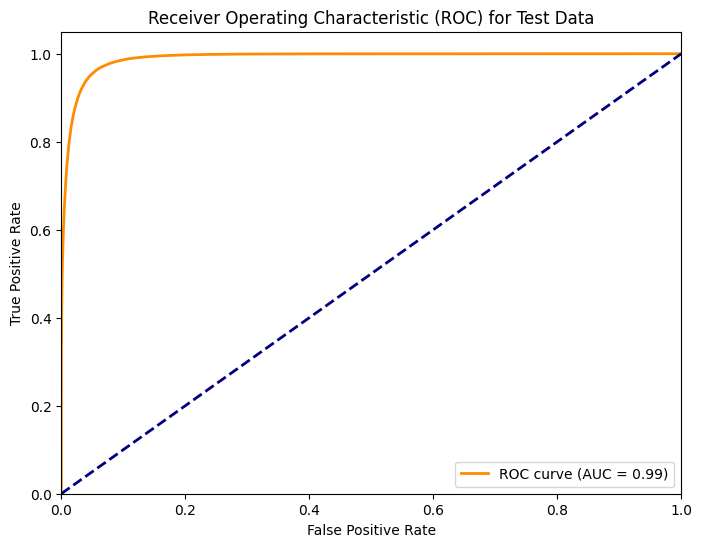

In [45]:
# Calculate the ROC curve for the test set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_probs_test)

# Calculate the AUC (Area Under the Curve) for the test set
roc_auc_test = auc(fpr_test, tpr_test)

# Plot the ROC curve for the test set
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Test Data')
plt.legend(loc='lower right')
plt.show()

In [46]:
# Evaluate the model
precision_rf = precision_score(y_test, y_pred_test)
recall_rf = recall_score(y_test, y_pred_test)
f1_score_rf = f1_score(y_test, y_pred_test)

print(f"Precision on Signal Test Data: {precision_rf:.4f}")
print(f"Recall on Signal Test Data: {recall_rf:.4f}")
print(f"F1-Score on Signal Test Data: {f1_score_rf:.4f}")

Precision on Signal Test Data: 0.9019
Recall on Signal Test Data: 0.7471
F1-Score on Signal Test Data: 0.8173


Here we can see a much better result. The model manages to predict most of the total signal files as well as the ones it is predicting (precision) is very high.
This is by far the better model so far.

# Oversampling

In [49]:
# First we load a subset of background and signal data -> Just like the baseline model
subset_percentage = 0.1
df_background = load_subset_data(background_files, 0, subset_percentage)
df_signal = load_subset_data(signal_files, 1, subset_percentage)

# Combine background and signal data
df_combined = pd.concat([df_background, df_signal])

# Shuffle the combined DataFrame
df_combined = shuffle(df_combined, random_state=fixed_seed)


To address the imbalance in our dataset, we apply oversampling to the the Minority Class (signal data). This involves duplicating signal entries to match the number of background entries, creating a balanced dataset for our model to train on.


In [52]:
# Oversample signal data to match the number of background samples
df_signal_oversampled = resample(df_signal,
                                 replace=True,                    
                                 n_samples=len(df_background),    
                                 random_state=fixed_seed)         

# Combine the oversampled signal data with the background data
df_oversampled = pd.concat([df_background, df_signal_oversampled])

# Shuffle the combined DataFrame to ensure a good mix
df_oversampled = shuffle(df_oversampled, random_state=fixed_seed).reset_index(drop=True)

In [53]:
# Count the number of signal and background entries
signal_count = df_oversampled[df_oversampled['label'] == 1].shape[0]
background_count = df_oversampled[df_oversampled['label'] == 0].shape[0]

print(f"Number of signal entries: {signal_count}")
print(f"Number of background entries: {background_count}")

Number of signal entries: 2244255
Number of background entries: 2244255


### Prepare Data for Training

In [54]:
# Prepare the feature matrix (X) and the target vector (y)
X = df_oversampled[features]
y = df_oversampled['label']

# Split the data into training and test sets using a 60-40 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=fixed_seed)


### Train the Random Forest Classifier - Oversampled

In [55]:
# Initialize the RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=fixed_seed)

# Start the timer
start_time = time.time()

# Train the model on the training data
rf_clf.fit(X_train, y_train)

# Calculate the training time
end_time = time.time()
training_time = end_time - start_time

# Calculate hours, minutes, and seconds
hours = int(training_time // 3600)
minutes = int((training_time % 3600) // 60)
seconds = int(training_time % 60)

# Format the training time
formatted_training_time = f"Time: {hours} hours, {minutes} minutes, {seconds} seconds"
print(formatted_training_time)


Time: 2 hours, 11 minutes, 41 seconds


### Evaluate the Model

Test Accuracy: 0.9993745140369521


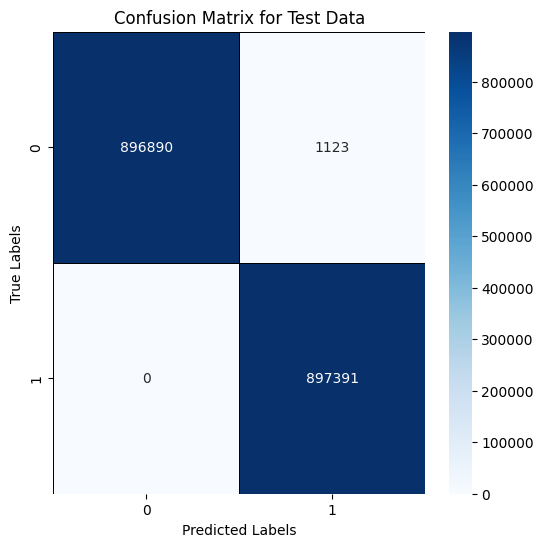

In [56]:
# Predict on the test set
y_pred_test = rf_clf.predict(X_test)
y_probs_test = rf_clf.predict_proba(X_test)[:, 1]  # Probability estimates for ROC curve on test data

# Calculate accuracy on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {accuracy_test}")

# Generate a confusion matrix for the test set predictions
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

# Plot the confusion matrix with custom formatting for the test data
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', linewidths=0.5, linecolor='black')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Test Data')
plt.show()


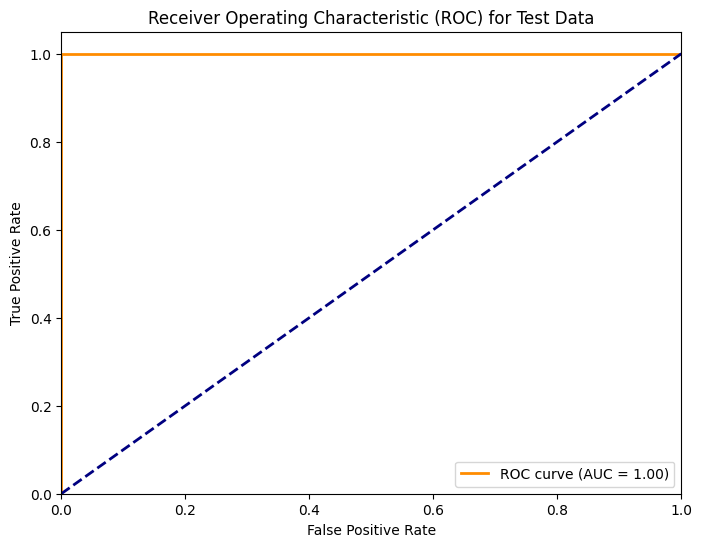

In [57]:
# Calculate the ROC curve for the test set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_probs_test)

# Calculate the AUC (Area Under the Curve) for the test set
roc_auc_test = auc(fpr_test, tpr_test)

# Plot the ROC curve for the test set
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Test Data')
plt.legend(loc='lower right')
plt.show()

In [58]:
# Evaluate the model
precision_rf = precision_score(y_test, y_pred_test)
recall_rf = recall_score(y_test, y_pred_test)
f1_score_rf = f1_score(y_test, y_pred_test)

print(f"Precision on Signal Test Data: {precision_rf:.4f}")
print(f"Recall on Signal Test Data: {recall_rf:.4f}")
print(f"F1-Score on Signal Test Data: {f1_score_rf:.4f}")

Precision on Signal Test Data: 0.9988
Recall on Signal Test Data: 1.0000
F1-Score on Signal Test Data: 0.9994


Oversampling can sometimes lead to overly optimistic performance metrics which seems to be the case here.


<!-- Oversampling can sometimes lead to overly optimistic performance metrics which seems to be the case here. -->

#### In part 2/3 of this notebook series, we will train a Neural Network model.